# Text analysis workbook



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/OZSW2025-data-driven-philosophy/blob/main/workbook_01_text_analysis.ipynb) 

Welcome to google colab! Colab is a cloud-based notebook environment that allows you to write and execute code in the python programming language in the browser. It follows a notebook structure (like jupyter) in which you can write markdown text like this, as well as code in cells that can be executed.

Below is one of these cells. You can run it either by clicking the little (▶️) button on the top left of the cell, or by clicking into it and then pressing shift+enter:


In [1]:
print("Hello World")


Hello World


If you want to continue working on this notebook, and make your own changes to the code, we'd reccomend you save your own copy, by clicking the "File" menu at the top left, and then "Save a copy in Drive". Please do this as it's easy to loose your work otherwise. You can then edit your own copy. You can also download it as an .ipynb file by clicking the "File" menu at the top left, "Download", and then "Download .ipynb". If you want to learn more about the functionalites of colab notebooks, we reccommend looking at this [basic colab features-notebook.](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

** Important:** Below we are going to run a LLM. This needs a more powerful computer, called an GPU. You can select this by doing Runtime -> Change Runtime Type -> T4 GPU.

# Part 1: Set-up
At the beginning of this notebook, we need to set up all of the libraries/packages (reusable python-programs other people have written) that we are going to use during this session. For this we use a common python-package manager called 'pip'. Pip takes care of downloading the right versions, and installing them on our computer, which in this case is a server that's standing in a google-data-center, maybe in Belgium or Iowa. These installs will take a minute or two.

In [ ]:
%%capture

!pip install pandas
!pip install pyalex
!pip install umap-learn
!pip install datamapplot
!pip install upgrade sentence-transformers 
!pip install seaborn
!pip install genieclust
!pip install litellm
!pip install opinionated
!pip install keybert
!pip install keyphrase-vectorizers
!pip install pystreamgraph

!pip install -q --upgrade "transformers>=4.45.2" "sentence-transformers>=3.0.1"
!pip install --upgrade 'nltk==3.8.1' 

!python3 -m spacy download en_core_web_sm # for English NER



#%pip install -q --upgrade "transformers==4.44.2" "sentence-transformers==2.7.0" "accelerate>=0.33" "keybert>=0.8.5" "torch>=2.2,<2.5"



# Check if utils directory exists, if not download from GitHub
import os
if not os.path.exists('utils'):
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/openalex_utils.py -P utils/
    !wget -q https://raw.githubusercontent.com/MNoichl/data-driven-philosophy-GAP2025/main/utils/streamgraph.py -P utils/
  
  
  
  



# Part 2: Imports

After setting up the packages, we need to import them. This makes the code in the packages available for us to use later. 

In [1]:
# Enable autoreload for development
# %load_ext autoreload
# %autoreload 2

# Core data science libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical computing and arrays
import os           # Operating system interface

# Visualization libraries
import matplotlib.pyplot as plt  # Basic plotting functionality
import seaborn as sns           # Statistical data visualization
from matplotlib.colors import rgb2hex

# Academic data access
import pyalex  # Interface to OpenAlex academic database

# Dimensionality reduction and clustering
import umap         # Uniform Manifold Approximation and Projection
import datamapplot  # Interactive visualization for high-dimensional data

# Natural language processing and AI
import sentence_transformers  # Sentence embeddings using transformer models
import litellm                # Unified interface for various LLM APIs
import spacy


# Styling and aesthetics
import opinionated  # Opinionated matplotlib styling
plt.style.use('opinionated_rc')
import colormaps as colormaps  # Extended colormap collection - https://pratiman-91.github.io/colormaps/

# progress bar
from tqdm import tqdm



from utils.openalex_utils import openalex_url_to_pyalex_query, process_records_to_df, get_records_from_dois, openalex_url_to_filename, download_openalex_records

/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/opinionated/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

# Part 3: Getting data

In this notebook we are interested in analysing textual data. For this we have prepared a dataset of texts from the *Stanford Encyclopedia of Philosophy*. Alternatively, we have set up code that allows you to quickly scrape your own dataset of abstracts from the *OpenAlex*-database. Finally, if you have your owns data-source to work with, we can show you how to hook it up to this notebook below. **Important:** You will only want to run one of the three sub-sections below. 

# Part 3.1 Stanford-Encyclopedia dataset

The code below downloads a zip-file of SEP-articles, and loads the texts into memory as a list, text_data.

In [82]:
import requests
import zipfile
from pathlib import Path

# Download and extract if needed
stanford_zip = Path("stanford-encyclopedia.zip")
stanford_folder = Path("stanford-encyclopedia")
if not stanford_folder.exists():
    zip_data = requests.get("https://github.com/MNoichl/data-driven-philosophy-GAP2025/raw/refs/heads/main/files/stanford-encyclopedia.zip").content
    with zipfile.ZipFile(zipfile.io.BytesIO(zip_data)) as zip_ref:
        zip_ref.extractall(".")

# Load data
text_data = [open(f, encoding='utf-8').read() for f in stanford_folder.glob("*.txt") if f.suffix in ['.txt', '.md']]
title_data = [f.stem for f in stanford_folder.glob("*") if f.suffix in ['.txt', '.md']]
# Extract year data from copyright strings in the text files
import re

year_data = []
for text in text_data:
    # Look for "Copyright © YYYY" pattern at the beginning of the text
    match = re.search(r'Copyright © (\d{4})', text)  
    if match:
        year_data.append(int(match.group(1)))
    else:
        year_data.append(None)  # If no copyright year found

used_dataset = "Stanford Encyclopedia"

print(len(text_data), len(title_data), len(year_data))

1843 1843 1843


## Part 3.2 OpenAlex-datasets.

We have written a function that takes in an arbitrary url to a OpenAlex search query, and downloads the abstracts associated with it. To use it, head over to [https://openalex.org](https://openalex.org), search for something you are interested in, and copy the web-address of your search address. Then replace the url behind ` openalex_url = `  with the new one. Make sure to keep the quotation marks around it. That tells python that this is a string of text, and not executable python code. 

In [ ]:
openalex_url = 'https://openalex.org/works?page=1&filter=primary_location.source.id:s255146,publication_year:2005-2025'

dataset_df = download_openalex_records(openalex_url,
                                       reduce_sample=True, 
                                       sample_reduction_method="n random samples", 
                                       sample_size=1000, 
                                       seed_value="42")


dataset_df['text'] = dataset_df['title'] + dataset_df['abstract'] 
# We filter for works that have an abstract:
dataset_df = dataset_df[dataset_df['text'].str.len() > 10]

text_data = list(dataset_df['text'])
year_data = dataset_df['publication_year']
title_data = dataset_df['title']

used_dataset = "OpenAlex-query"






# 3.3 Bring your own data

Below you can hook up your own dataset. The remainder of the notebook expects `text_data`and  `title_data`to be lists of strings, and  `year_data`to be a list of numbers.


In [ ]:
text_data = "..."
title_data = "..."
year_data = "..."

used_dataset = "NAME YOUR DATASET HERE"

# Part 4: Named Entity Recognition (NER)

Named entity recognition is a branch of natural language processing (NLP). Within an NLP pipeline, it is a relatively late step:

<center><img src='./files/NER_NLP_pipeline.png' width=700></center>

This is because it needs to receive a tokenized text and, in some languages, it needs to understand a word's part-of-speech (POS) to perform well. To determine whether a particular part of a text is a name, our model relies on a tokenization (splitting) of the text and its tagging for a particular part of speech (noun, verb, etc.). 

*(Graphic from William Mattingly, CC-BY, 2022 Text Analysis Pedagogy Institute)*

In [ ]:
nlp = spacy.load("en_core_web_sm")

Tokenization distinguishes full stops that end sentences from those that occur in abbreviations and initials (like G. E. Moore) - simply splitting by `.` would not give the right result.

In [ ]:
text = "G.E. Moore is known as a good writer. Perhaps he is also good at programming?"

We can run the basic spacy pipeline on our text object like so:

In [ ]:
doc = nlp(text)

The resulting doc object is structured. We can inspect its sentences:

In [ ]:
list(doc.sents)

The spacy nlp pipeline also extracts a list of entities. Each entity has a text attribube (from the text source) and a label attribute, which we can inspect:

In [ ]:
[(ent.text, ent.label_) for ent in doc.ents]

This processing of the raw text into a doc object follows a number of steps that we can inspect (and adapt). 

In [ ]:
nlp.pipe_names

## Looking at the Stanford Encyclopedia

Instead of looking at a toy sentence, we can process articles from the Stanford Encyclopedia. Here for a single (arbitrary) article:

In [ ]:
doc = nlp(text_data[42])

The NER will now try to detect (and distinguish) persons, organizations, etc. If we only look at the entities tagged as persons:

In [ ]:
[(ent.text, ent.label_) for ent in doc.ents if ent.label_=='PERSON'][0:20]

In [ ]:
print(f'We find {len([ent for ent in doc.ents if ent.label_=="PERSON"])} person labelled entities')

We can summarize this with a Counter object:

In [ ]:
from collections import Counter
count = Counter()
count.update([ent.text for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

And clean some of the labels by removing the year-strings - this is also important to sum over variants.

In [ ]:
def strip_years(text):
    """
    Clean years and punctuation from labels.
    """
    return re.sub("\s?[0-9]|['|.)(]",'', text)

strip_years("Kant's new add")

In [ ]:
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

But have all person names been understood correctly? let's look at the Organizations.

In [ ]:
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='ORG'])
count.most_common(10)

A lot of these organization tags are actually referring to people - unsurprising, since many organizations are named after people. So we should expect some errors when trying to distinguish these automatically. 

In our specific case, we have background knowledge - we expect people to be mentioned much more than companies or organizations. And we know that many of these names are philosophers that should be tagged as persons. To take this into account, we can add an extra step in the NER pipeline.

## Adding an entity ruler

We can add explicit rules for detecting entities with an 'entity ruler'. This acts as an additional step in the spaCy pipeline.

In [ ]:
names = ['Stoljar', 'Benson', 'Kymlicka'] # These can be many, feel free to add your own...
patterns = [{"label":"PERSON", "pattern":name} for name in names]

In [ ]:
nlp.pipe_names

In [ ]:
nlp2 = spacy.load("en_core_web_sm", exclude=["tagger","parser","lemmatizer","attribute_ruler"])

In [ ]:
entruler = spacy.blank('en') # Create a blank English model
nlp_rules = nlp2.add_pipe("entity_ruler", before='ner') # specify that the EntityRuler comes before built-in NER
nlp_rules.add_patterns(patterns)

In [ ]:
nlp2.pipe_names

The entity ruler now tags the patterns we have defined as persons, before we run the standard NER component. 

In [ ]:
doc2 = nlp2(text_data[42])

In [ ]:
count2 = Counter()
count2.update([strip_years(ent.text) for ent in doc2.ents if ent.label_=='PERSON'])
count2.most_common(10)

Compare again with the top names without our entity ruler:

In [ ]:
doc = nlp(text_data[42])
count = Counter()
count.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])
count.most_common(10)

Now the explicitly mentioned names are taken into account. Of course, in the raw text there are many more phrases and words that we might want to include as mentions of e.g. Kant:

In [ ]:
c = Counter()
c.update([strip_years(word) for word in text_data[42].split(' ') if re.match('Kant', word)])

In [ ]:
print(c)

Is 'Kant' mentioned when Korsgaard is described as a Kantian? Even simple counting needs to answer some conceptual questions.

## Running on the full corpus
(not efficient, can take a while...) Here we are only taking the first 10

In [ ]:
from tqdm import tqdm
import os

# Sample n random documents if desired
import random

sampled_texts = random.sample(text_data, 100)


docs = list(
    tqdm(
        nlp2.pipe(sampled_texts, batch_size=1, n_process=max(os.cpu_count()-1, 1)),
        total=len(sampled_texts),
        unit="doc",
        mininterval=0.2
    ))

In [ ]:
corpcount = Counter()
for doc in docs:
    corpcount.update([strip_years(ent.text) for ent in doc.ents if ent.label_=='PERSON'])

In [ ]:
print(corpcount.most_common()[0:10])

In [ ]:
import matplotlib.pyplot as plt

# Get top 20 most common names
top_20 = corpcount.most_common(20)
names = [item[0] for item in top_20]
counts = [item[1] for item in top_20]

# Create horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(names, counts, color='#980f0e')
plt.xlabel('Count')
plt.ylabel('Names')
plt.title('Top 20 Most Mentioned Philosophers/Thinkers')
plt.gca().invert_yaxis()  # To show highest count at top
plt.tight_layout()
plt.show()


# Part 5: Using a language model 
We are now going to use a text-embedding model (a relatively small large language model) to transform the texts into a format which is easier to analyze mathematically.  The most famous of these models is called BERT (Bidirectional encoder representations from transformers), but there are many models you can choose from for this purpose. Look around e. g. here: [https://www.sbert.net/docs/sentence_transformer/pretrained_models.html ](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html )

While they are trained on different datasets and can have a variety of different architectures, their main principles are very similar: Sub-word-particles, called tokens, are associated with long strings of numbers, called embeddings. These embeddings learned during the training-process. When presented with new texts, as we are going to do below, the model cuts the text up into the tokens, and selects the associated embeddings. The embeddings then undergo a process called 'attention' in which the individual representations interact with, and change each-other. In this process, the model adapts the individual embeddings to their context, and changes e.g. the embeddings associated with 'bank', depending on whether the word is close to 'river', as opposed to 'deposit'. Finally, the embeddings of all the tokens in the text get summarized, e.g. by averaging thm. This final embedding, whihc contains information from all the tokens then gets used to represent the whole text.



In [84]:
from sentence_transformers import SentenceTransformer

model_name = "all-mpnet-base-v2" # "answerdotai/ModernBERT-base",  "Qwen/Qwen3-Embedding-0.6B"
model = SentenceTransformer(model_name) #thenlper/gte-small
embeddings = model.encode([x[:3000] for x in text_data],
                          show_progress_bar=True)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 741285b9-17ce-4aa1-b01b-6295727b87c9)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
Batches: 100%|██████████| 58/58 [00:44<00:00,  1.29it/s]


This is what the resulting embeddings look like - each row represents one of our texts:


In [85]:
print(embeddings)

[[ 0.00861665 -0.00242311 -0.02547939 ...  0.00446065 -0.00274284
  -0.02218162]
 [ 0.004137    0.04203364 -0.01169875 ...  0.04284021  0.01554795
  -0.02053516]
 [ 0.05635183  0.00303171 -0.01757173 ...  0.02967447  0.01793753
   0.04160102]
 ...
 [ 0.03108224  0.024783   -0.04337657 ...  0.00832014 -0.00360857
  -0.03637759]
 [ 0.02651902  0.05491805 -0.00015293 ...  0.04351029  0.03547029
   0.0052364 ]
 [ 0.00525316  0.00098338  0.00165149 ...  0.03760115 -0.05371822
   0.0469291 ]]


# Part 6: applying dimensionality reduction


The attractive thing about text embeddings is that we can calculate similarities between them, which will, due the way that the embedding model is trained, reflect the how similar the topics of the texts are. One way of analyzing these similarities is by using UMAP (Uniform Manifold approximation and Projection). What UMAP effectively does is compute a nearest-neighbour graph, in which each text is linked to the other texts that are most similar to it, reweigh the graph so that high density areas don't dominate, and then layout the resulting network in a lower dimensional space using a force based simulation, in which linked nodes are pulled together, while unconnected nodes are pushed apart. This reproduces important features of outr dataset, whoch originally where encoded in several hundred dimensions in two. For an intuitive explanation to umap, see: [https://pair-code.github.io/understanding-umap/](https://pair-code.github.io/understanding-umap/). Below we produce a layout in two dimensions:

In [86]:
import umap


reducer = umap.UMAP(n_components=2, random_state=42,metric='cosine')
umap_embeddings = reducer.fit_transform(embeddings)

print(umap_embeddings)


/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[ 7.4865646   2.477024  ]
 [10.362078    9.047452  ]
 [ 8.338385    0.25094372]
 ...
 [10.226493    4.363775  ]
 [11.979002    7.6949177 ]
 [ 7.920188    1.9952396 ]]


We can also look at the embeddings as a scatter-plot. Each data-point is one of our texts. Note that while the below looks like a scatter plot, the x- and y-axes hold no information. The plot is rotation-invariant, and only the distances between the datapoints are relevant. 

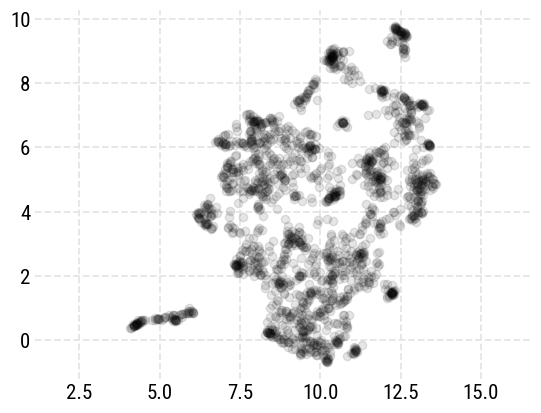

In [87]:
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],alpha=0.1, c='black')
plt.axis('equal')
plt.show()

# Part 5: Clustering 

To get a better idea of what the the different areas of the plot mean, we can employ clustering. Because the 2-d umap looses a lot of information (768 Dimensions just don't fit that well into 2), and most clustering-algorithms struggle with high dimensional data due to the so-caled *curse of dimensionality*, we run another UMAP-reduction to 30 dimensions, on which we cluster. Here we employ genieclust, a flexible version of agglomerative clustering([https://genieclust.gagolewski.com/weave/basics.html](https://genieclust.gagolewski.com/weave/basics.html)), that allows us to tune how imbalanced we allow cluster sizes to be.

In [88]:
import genieclust

reducer = umap.UMAP(n_components=30, random_state=42,metric='cosine')
umap_embeddings_high_dim = reducer.fit_transform(embeddings)

g = genieclust.Genie(n_clusters=15, gini_threshold=0.3)
cluster_labels = g.fit_predict(umap_embeddings_high_dim)
print(cluster_labels[0:20])

/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[ 0  1  2  3  4  5  2  2  6  7  8  9  3 10  2  1  7 11  3  9]


We now create a dictionary of colors, which we can use in all the later plots:

In [89]:
# Get unique cluster labels
unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters)

# Get colors from antique colormap, repeating if necessary
antique_colors = colormaps.antique(np.linspace(0, 1, colormaps.antique.N))
repeated_colors = np.tile(antique_colors, (n_clusters // colormaps.antique.N + 1, 1))[:n_clusters]

custom_color_map = dict(
    zip(
        unique_clusters,
        map(rgb2hex, repeated_colors)
    )
)

And then we plot the umap from above with the clusters overlayed on top:

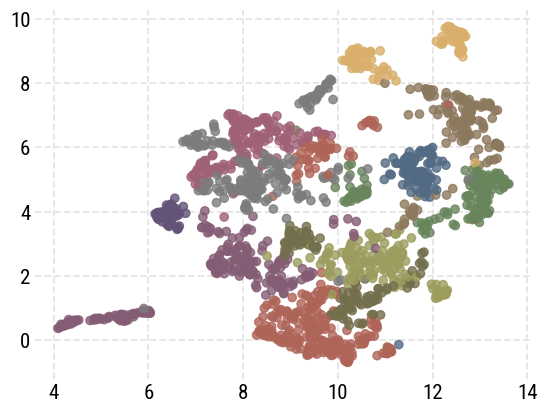

In [90]:
plt.scatter(x=umap_embeddings[:, 0], 
            y=umap_embeddings[:, 1],
            c=[custom_color_map[x] for x in cluster_labels],
            alpha=0.8)

# Part 6: Labeling clusters

We now want to find out what our clusters actually contain. One quick, and a little drity way to do this is to simpy show examples from each cluster to an LLM, and have it come up with a name for it. As we are using a strong LLM here via an API, we need to add an API-key in place of the "..." below. API keys are secrets that are directly connected to our credit-cards, so we have to treat them carefully! We are going to send the key for this workshop out via E-Mail.

In [93]:
API_KEY = "..."


if API_KEY == "...": # This code below is only for local development. You can ignore it!
    with open('API_KEYS.txt', 'r') as file:
        for line in file:
            if line.startswith('OPENAI:'):
                API_KEY = line.split(':', 1)[1].strip()
                break
        else:
            raise ValueError("OPENAI API key not found in API_KEYS.txt")

os.environ["OPENAI_API_KEY"] = API_KEY

Now we can  create our labels. The `label_cluster`function takes in a list of text from each cluster, takes a random sample, and, using the prompt, asks the LLM to name them. Feel free to play with the prompt to steer the labels into the right direction. 

In [133]:
from litellm import completion
import pandas as pd
import random
import json

# Create a function to label clusters using OpenAI
def label_cluster(cluster_texts, cluster_id, n_samples=10, extra_prompt=""):
    # Randomly sample representative texts from the cluster (max 10 for efficiency)
    sample_size = min(10, len(cluster_texts))
    sample_texts = random.sample(cluster_texts, sample_size)
    
    # Truncate texts to 100 characters
    sample_texts = [text[:1000] + "..." if len(text) > 1000 else text for text in sample_texts]
    
    prompt = f"""
    Below are randomly sampled texts from cluster {cluster_id}. Please analyze these texts and provide:
    1. A short descriptive label (2-4 words). 
    2. A brief description of the main theme.
    {extra_prompt}

    Texts:
    {chr(10).join([f"- {text[:200]}..." if len(text) > 200 else f"- {text}" for text in sample_texts])}
    
    Please respond in JSON format:
    {{
        "label": "[your label]",
        "description": "[your description]"
    }}
    """
    
    messages = [{"content": prompt, "role": "user"}]
    response = completion(model="openai/gpt-5", messages=messages, response_format={"type": "json_object"})
    return response.choices[0].message.content

# Group texts by cluster
cluster_groups = {}
for i, label in enumerate(cluster_labels):
    if label not in cluster_groups:
        cluster_groups[label] = []
    cluster_groups[label].append(text_data[i])

# Label each cluster
cluster_info = {}
for cluster_id, texts in cluster_groups.items():
    print(f"Labeling cluster {cluster_id} ({len(texts)} texts)...")
    label_info = label_cluster(texts, cluster_id, n_samples=5, extra_prompt="Note that the clusters are areas of philosophy that the texts are from. Try to pick labels that are commonly used to describe areas of philosophy.")
    cluster_info[cluster_id] = label_info
    print(f"Cluster {cluster_id}: {label_info}\n")

# Create a summary dataframe
cluster_summary = []
for cluster_id, info in cluster_info.items():
    # Parse the JSON response
    try:
        parsed_info = json.loads(info)
        label = parsed_info.get('label', 'Unknown')
        description = parsed_info.get('description', 'No description available')
    except (json.JSONDecodeError, TypeError):
        # Fallback if JSON parsing fails
        label = f"Cluster {cluster_id}"
        description = str(info)
    
    cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Size': len(cluster_groups[cluster_id]),
        'Label': label,
        'Description': description
    })

cluster_df = pd.DataFrame(cluster_summary)
cluster_df

Labeling cluster 0 (160 texts)...


KeyboardInterrupt: 

We also do some data-wrangling, to have one long list of labels for each data-point, and to update our label-dictionary:

In [95]:
# Create a labels list from cluster_labels and the labeled cluster descriptions
labels_list = []
for cluster_id in cluster_labels:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    labels_list.append(label)

# Update the custom_color_map to use cluster labels instead of cluster IDs
custom_color_map = {}
for cluster_id in unique_clusters:
    # Find the corresponding label from the cluster_df
    cluster_row = cluster_df[cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    
    # Get the color for this cluster_id from the original mapping
    color_index = list(unique_clusters).index(cluster_id)
    color = rgb2hex(repeated_colors[color_index])
    custom_color_map[label] = color




# Part 7: Visualizing

## 7.1 An interactive data-map

To bring everything we've done so far together, we produce an interactive map of our datast. This includes the umap, the clusters and the labels. On hovering over the datapoints we can see their titles. This allows us to explore the structure of our dataset, as well investigate properties, and potential failures of our data and pipeline. 

<InteractiveFigure width=100% height=800>
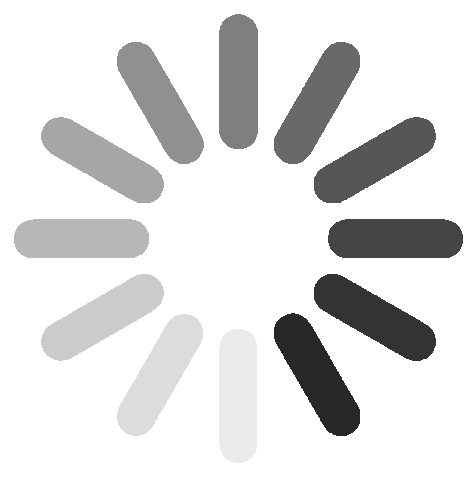

In [97]:
import datamapplot

datamapplot.create_interactive_plot(
    umap_embeddings,
    labels_list,  
    hover_text=[x.title() for x in title_data],  
    label_color_map=custom_color_map,
    title=used_dataset
)

## 7.2 Historical developments

One common application of topic-modelling/clustering is to investigate the historical development of a corpus. An easy way to accomplish this is a stream-graph, in which the size of each cluster changes as a function of time. We first have to do some data-wrangling:

In [98]:
# Prepare data for streamgraph visualization
# Convert the year_data and clusters into the format expected by plot_streamgraph

# Get unique years and sort them
years_sorted = sorted(set(year_data))
X_stream = np.array(years_sorted)

# Get unique clusters and their labels
unique_clusters = sorted(set(cluster_labels))
cluster_labels_to_plot = []
for cluster_id in unique_clusters:
    if cluster_id in cluster_df['Cluster_ID'].values:
        label = cluster_df[cluster_df['Cluster_ID'] == cluster_id]['Label'].iloc[0]
        cluster_labels_to_plot.append(label)
    else:
        cluster_labels_to_plot.append(f"Cluster {cluster_id}")

# Create Y matrix: each row is a cluster's values over time
Y_stream = []
for cluster_id in unique_clusters:
    cluster_values = []
    for year in years_sorted:
        # Count documents in this cluster for this year
        cluster_count = sum(1 for i, (doc_year, doc_cluster) in enumerate(zip(year_data, cluster_labels)) 
                           if doc_year == year and doc_cluster == cluster_id)
        cluster_values.append(cluster_count)
    Y_stream.append(cluster_values)

Y_stream = np.array(Y_stream)

print(f"Streamgraph data prepared:")
print(f"X (years): {len(X_stream)} points from {X_stream[0]} to {X_stream[-1]}")
print(f"Y (clusters): {Y_stream.shape[0]} clusters × {Y_stream.shape[1]} time points")
print(f"Cluster labels: {cluster_labels_to_plot[:3]}...")  # Show first 3 labels


Streamgraph data prepared:
X (years): 23 points from 2003 to 2025
Y (clusters): 15 clusters × 23 time points
Cluster labels: ['Philosophy of Mind', 'Ancient and Medieval Philosophy', 'Logic, Language, and Computation']...


There is no good streamgraph-library in python that we know of, so we made our own and import it here. This version can sort the clusters by size over time, showing which clusters grow and fade proportionally, as well as the growth of the corpus as a whole in absolute numbers.

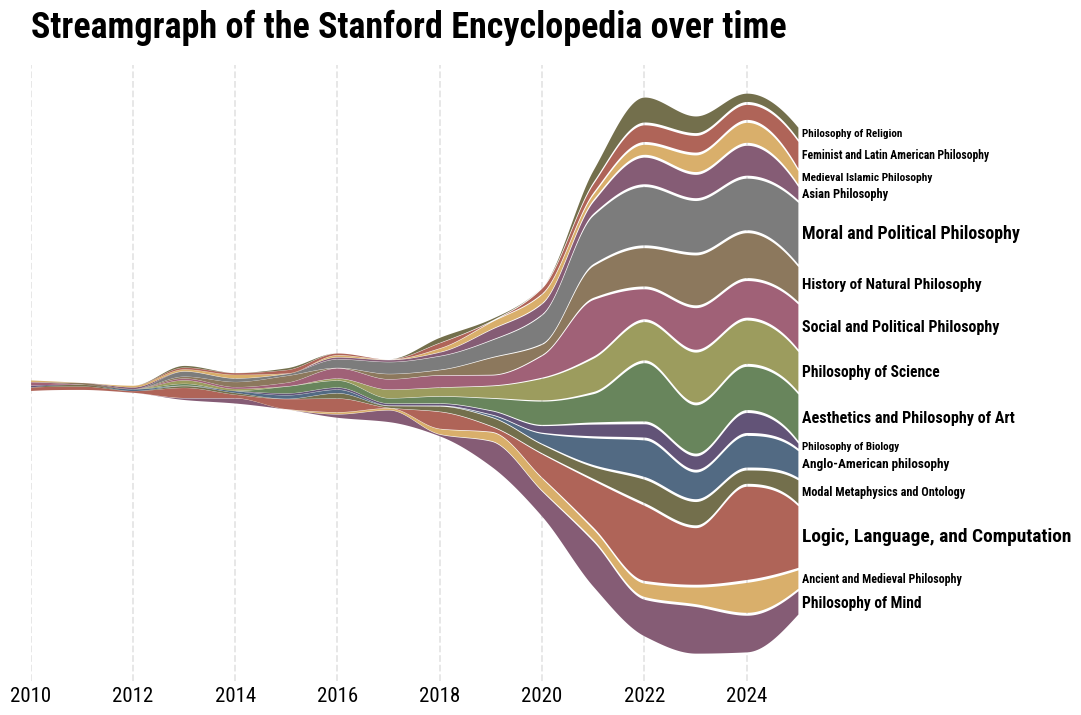

In [117]:
from pystreamgraph import plot_streamgraph, order_bestfirst, order_twoopt


order = order_twoopt(X_stream[7:], Y_stream[:,7:], repeats=12, scans=4)


fig, ax = plt.subplots(figsize=(10, 8))

plot_streamgraph(X_stream[7:], 
                 Y_stream[:,7:], 
                labels=cluster_labels_to_plot,
                cmap=custom_color_map,
                wiggle_reduction="weighted",
                sorted_streams=False,  # Keep original stream order
                label_position='end',  # Use annealed placement to avoid overlaps
                curve_samples=24,  # Smooth curve interpolation
                label_fontsize_min=8,  # Minimum font size for smaller streams
                label_fontsize_max=14,  # Maximum font size for larger streams
                label_color='black',
                label_edge_offset_frac=0.005,
                label_anchor='middle_center',
                ax=ax,
                )

plt.title("Streamgraph of the {} over time".format(used_dataset))
plt.gca().yaxis.set_visible(False)

# Getting embeddings for specific words

Instead of embedding the whole texts, we can also compute embeddings for individual tokens, or token-sequences. This allows us to trace the semantics of individual words, at least in so far as they are determined by their contexts, as understood by the llm.
The two codeblocks first extract all the contexts of a keyphrase, and then extract the representations corresponding to the key-phrase from the embedding of the whole context.

In [142]:
key_phrase = "epistemic "

def extract_context_around_phrase(text_data, key_phrase, sentences_before=2, sentences_after=2):
    """
    Extract text chunks around occurrences of a key phrase, including surrounding sentences.
    
    Parameters:
    - text_data: list of strings or single string containing the text(s) to search
    - key_phrase: string to search for
    - sentences_before: number of sentences to include before the key phrase
    - sentences_after: number of sentences to include after the key phrase
    
    Returns:
    - list of dictionaries with 'text', 'doc_index', and 'phrase_position' keys
    """
    import re
    
    # Ensure text_data is a list
    if isinstance(text_data, str):
        text_data = [text_data]
    
    contexts = []
    
    for doc_idx, text in enumerate(text_data):
        # Split text into sentences (simple approach using periods, exclamation marks, question marks)
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]  # Remove empty sentences
        
        # Find sentences containing the key phrase
        for sent_idx, sentence in enumerate(sentences):
            if key_phrase.lower() in sentence.lower():
                # Calculate context window
                start_idx = max(0, sent_idx - sentences_before)
                end_idx = min(len(sentences), sent_idx + sentences_after + 1)
                
                # Extract context sentences
                context_sentences = sentences[start_idx:end_idx]
                context_text = '. '.join(context_sentences)
                
                # Add period at the end if not present
                if not context_text.endswith(('.', '!', '?')):
                    context_text += '.'
                
                contexts.append({
                    'text': context_text,
                    'doc_index': doc_idx,
                    'phrase_position': sent_idx,
                    'sentence_range': (start_idx, end_idx-1)
                })
    
    return contexts

# Extract contexts around the key phrase
contexts = extract_context_around_phrase(text_data, key_phrase, sentences_before=2, sentences_after=2)
context_texts = [context['text'] for context in contexts]
for x in contexts:
    x['year'] = year_data[x['doc_index']]



We can check what this looks like:

In [138]:

contexts[0:3]

[{'text': '2. 2 Access Consciousness and No-Report Paradigms Introspection illustrates a type of cognitive access, for a state that is introspected is access conscious. This raises a question that has epistemic implications: is access consciousness necessary for phenomenal consciousness. If it is not, then there can be phenomenal states that are not access conscious, so are in principle not reportable. That is, phenomenal consciousness can overflow access consciousness (Block 2007).',
  'doc_index': 0,
  'phrase_position': 230,
  'sentence_range': (228, 232),
  'year': 2024},
 {'text': 'An emphasis on intentional action embraces a broader evidential basis for consciousness. Consider the Intentional Action Inference to phenomenal consciousness: If some subject acts intentionally, where her action is guided by a perceptual state, then the perceptual state is phenomenally conscious. An epistemic version takes the action to provide good evidence that the state is conscious. Notice that int

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

def phrase_vectors(key_phrase, texts, model_name="sentence-transformers/all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    tok = model._first_module().tokenizer
    needle = key_phrase.lower()
    out = []

    for text in tqdm(texts):
        enc = tok(text, return_offsets_mapping=True, return_tensors="pt")
        offsets = enc["offset_mapping"][0].tolist()  # (start_char, end_char) per token

        with torch.no_grad():
            token_embs = model.encode(text, output_value="token_embeddings", convert_to_tensor=True, show_progress_bar=False)
            # This is a bit inefficient, because we are not batching, but should be fine for most cases.

        spans, i, hay = [], 0, text.lower()
        while True:
            i = hay.find(needle, i)
            if i == -1: break
            spans.append((i, i + len(needle)))
            i += 1

        idxs = [t for t,(a,b) in enumerate(offsets)
                if b > 0 and any(not (b <= s or a >= e) for s,e in spans)]

        out.append(token_embs[idxs].mean(0).cpu() if idxs else None)

    return out

key_phrase_embeddings = np.array(phrase_vectors(key_phrase, context_texts, model_name="answerdotai/ModernBERT-base"))


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5c47a494-cb0a-4431-8995-a084ceb67d4f)')' thrown while requesting HEAD https://huggingface.co/answerdotai/ModernBERT-base/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
No sentence-transformers model found with name answerdotai/ModernBERT-base. Creating a new one with mean pooling.
100%|██████████| 6094/6094 [04:45<00:00, 21.35it/s]


We can again use umap for low dimensional, explorable embeddings, and genieclust to cluster. As we expect there to be one, or a few dominant meanings, we choose a higher target-genie-coeffiecient here. 

In [140]:
import umap


key_phrase_reducer = umap.UMAP(n_components=2, random_state=42,metric='cosine')
key_phrase_umap_embeddings = key_phrase_reducer.fit_transform(key_phrase_embeddings)

print(key_phrase_umap_embeddings)


/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[ 5.995097  12.526265 ]
 [ 3.9241683 12.820642 ]
 [ 1.4253305 11.782919 ]
 ...
 [ 4.28206   13.867502 ]
 [ 1.8151672 11.108979 ]
 [ 1.6997412 10.889171 ]]


/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


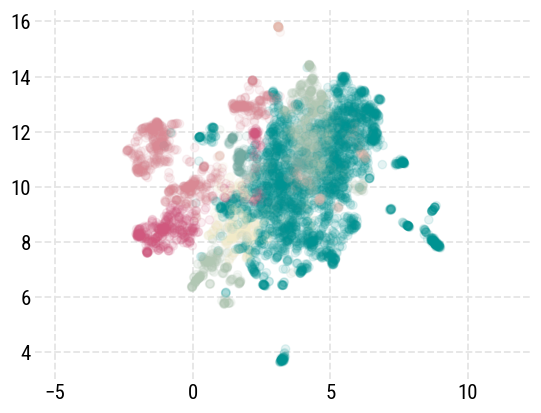

In [150]:
import genieclust

key_phrase_high_dim_reducer = umap.UMAP(n_components=30, random_state=42,metric='cosine')
key_phrase_high_dim_umap_embeddings = key_phrase_high_dim_reducer.fit_transform(key_phrase_embeddings)

g = genieclust.Genie(n_clusters=15, gini_threshold=0.6)
concept_cluster_labels = g.fit_predict(key_phrase_high_dim_umap_embeddings)


n_clusters = len(np.unique(concept_cluster_labels))
cb_colors = colormaps.tealrose(np.linspace(0, 1, colormaps.tealrose.N))
repeated_concept_colors = np.tile(cb_colors, (n_clusters // colormaps.tealrose.N + 1, 1))[:n_clusters]

custom_concept_color_map = dict(zip(np.unique(concept_cluster_labels),map(rgb2hex, repeated_concept_colors)))

plt.scatter(key_phrase_umap_embeddings[:, 0], key_phrase_umap_embeddings[:, 1],alpha=0.1, c=[custom_concept_color_map[x] for x in concept_cluster_labels])
plt.axis('equal')
plt.show()

We can also reuse the labeling code from above:

In [151]:
# Group texts by concept cluster
concept_cluster_groups = {}
for i, label in enumerate(concept_cluster_labels):
    if label not in concept_cluster_groups:
        concept_cluster_groups[label] = []
    concept_cluster_groups[label].append(contexts[i]['text'])

# Label each concept cluster
concept_cluster_info = {}
for cluster_id, texts in concept_cluster_groups.items():
    print(f"Labeling concept cluster {cluster_id} ({len(texts)} texts)...")
    label_info = label_cluster(texts, cluster_id, n_samples=5, extra_prompt=f"Note that these are clusters of text contexts containing the key phrase '{key_phrase}'. Try to pick labels that describe the different conceptual uses or meanings of this phrase.")
    concept_cluster_info[cluster_id] = label_info
    print(f"Concept cluster {cluster_id}: {label_info}\n")

# Create a summary dataframe
concept_cluster_summary = []
for cluster_id, info in concept_cluster_info.items():
    # Parse the JSON response
    try:
        parsed_info = json.loads(info)
        label = parsed_info.get('label', 'Unknown')
        description = parsed_info.get('description', 'No description available')
    except (json.JSONDecodeError, TypeError):
        # Fallback if JSON parsing fails
        label = f"Concept Cluster {cluster_id}"
        description = str(info)
    
    concept_cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Size': len(concept_cluster_groups[cluster_id]),
        'Label': label,
        'Description': description
    })

concept_cluster_df = pd.DataFrame(concept_cluster_summary)
concept_cluster_df

Labeling concept cluster 0 (2960 texts)...
Concept cluster 0: {
  "label": "Epistemic norms and models",
  "description": "Explores how inquiry and knowledge are modeled and evaluated: epistemic landscape models and cognitive diversity in science, types of epistemic reduction, theory-ladenness and perceptual justification, peer disagreement and relativism about knowledge ascriptions, and the role of coherence and shared practices in achieving understanding."
}

Labeling concept cluster 1 (182 texts)...
Concept cluster 1: {
  "label": "Epistemic justification debates",
  "description": "Texts contrast theories of what makes beliefs justified or rational—internalism, reliabilism, evidentialism, and coherence—emphasizing reflection, evidence-responsiveness, doxastic control, and inductive norms, with cases (e.g., clairvoyance, medical evidence) testing these standards."
}

Labeling concept cluster 2 (654 texts)...
Concept cluster 2: {
  "label": "Formal and Social Epistemology",
  "descri

Cluster_ID  Size                                  Label  \
0            0  2960             Epistemic norms and models   
1            1   182        Epistemic justification debates   
2            2   654         Formal and Social Epistemology   
3            3    97          Epistemic normativity debates   
4            4    66             Epistemic virtues and aims   
5            5   396                 Formal Epistemic Logic   
6            6   390                Dynamic Epistemic Logic   
7            7   179            Epistemic Norms and Reasons   
8            8    83         Contextual epistemic pluralism   
9            9   246               Epistemic utility theory   
10          10   188        Epistemic Norms and Rationality   
11          11    75        Epistemic Norms & Justification   
12          12   364             Epistemic norms and values   
13          13   100  Externalism and Epistemic Possibility   
14          14   114      Epistemic Instruments and Objects   

                                          Description  
0   Explores how inquiry and knowledge are modeled...  
1   Texts contrast theories of what makes beliefs ...  
2   Explores how knowledge and information are mod...  
3   Uses of ‘epistemic’ to mark normative standard...  
4   Discussion of epistemic virtues and normative ...  
5   Texts focus on logical frameworks (S5, multi-a...  
6   Formal frameworks for modeling knowledge and b...  
7   Debates about how epistemic standards—evidence...  
8   Explores how epistemic merit and evidential su...  
9   Decision-theoretic evaluation of beliefs using...  
10  Debates over standards for justified belief an...  
11  Debates about what makes belief rational or ju...  
12  Explores how epistemic standards, incentives, ...  
13  Explores how semantic/content externalism and ...  
14  Explores how knowledge is gained via epistemic...

In [158]:
# Create a labels list from concept_cluster_labels and the labeled concept cluster descriptions
concept_labels_list = []
for cluster_id in concept_cluster_labels:
    # Find the corresponding label from the concept_cluster_df
    cluster_row = concept_cluster_df[concept_cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    concept_labels_list.append(label)

# Update the custom_color_map to use concept cluster labels instead of cluster IDs
concept_custom_color_map = {}
unique_concept_clusters = sorted(set(concept_cluster_labels))
for cluster_id in unique_concept_clusters:
    # Find the corresponding label from the concept_cluster_df
    cluster_row = concept_cluster_df[concept_cluster_df['Cluster_ID'] == cluster_id]
    label = cluster_row.iloc[0]['Label']
    
    # Get the color for this cluster_id from the original mapping
    color_index = list(unique_concept_clusters).index(cluster_id)
    color = rgb2hex(repeated_concept_colors[color_index])
    concept_custom_color_map[label] = color


In [159]:
concept_labels_list

['Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic justification debates',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Formal and Social Epistemology',
 'Epistemic norms and models',
 'Formal and Social Epistemology',
 'Formal and Social Epistemology',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Epistemic normativity debates',
 'Epistemic normativity debates',
 'Epistemic normativity debates',
 'Epistemic normativity debates',
 'Epistemic normativity debates',
 'Epistemic normativity debates',
 'Epistemic norms and models',
 'Epistemic virtues and aims',
 'Formal Epistemic Logic',
 'Epistemic norms and models',
 'Epistemic norms and models',
 'Dynamic Epistemic Logic',
 'Dynamic Epistemic Logic',
 'Dynamic Epistemic Logic',
 'Formal Epistemi

In [160]:
concept_custom_color_map

{'Epistemic norms and models': '#009392',
 'Epistemic justification debates': '#72aaa1',
 'Formal and Social Epistemology': '#b1c7b3',
 'Epistemic normativity debates': '#f1eac8',
 'Epistemic virtues and aims': '#e5b9ad',
 'Formal Epistemic Logic': '#d98994',
 'Dynamic Epistemic Logic': '#d0587e',
 'Epistemic Norms and Reasons': '#009392',
 'Contextual epistemic pluralism': '#72aaa1',
 'Epistemic utility theory': '#b1c7b3',
 'Epistemic Norms and Rationality': '#f1eac8',
 'Epistemic Norms & Justification': '#e5b9ad',
 'Epistemic norms and values': '#d98994',
 'Externalism and Epistemic Possibility': '#d0587e',
 'Epistemic Instruments and Objects': '#009392'}

<InteractiveFigure width=100% height=800>
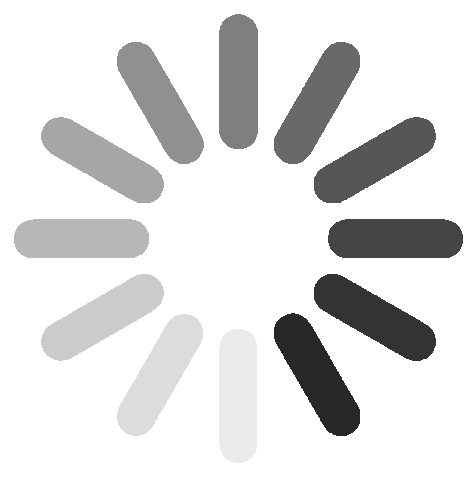

In [162]:
import datamapplot

datamapplot.create_interactive_plot(
    key_phrase_umap_embeddings,concept_labels_list,
    hover_text=[text.replace(key_phrase, f" █{key_phrase}█ ") for text in context_texts],  
    label_color_map=concept_custom_color_map,
    title=f"{used_dataset} - {key_phrase}"
)

We can also, inspired by Zichert, Simons and Wüthrich (2025) analyze how the coherence of the concept changes over time. 

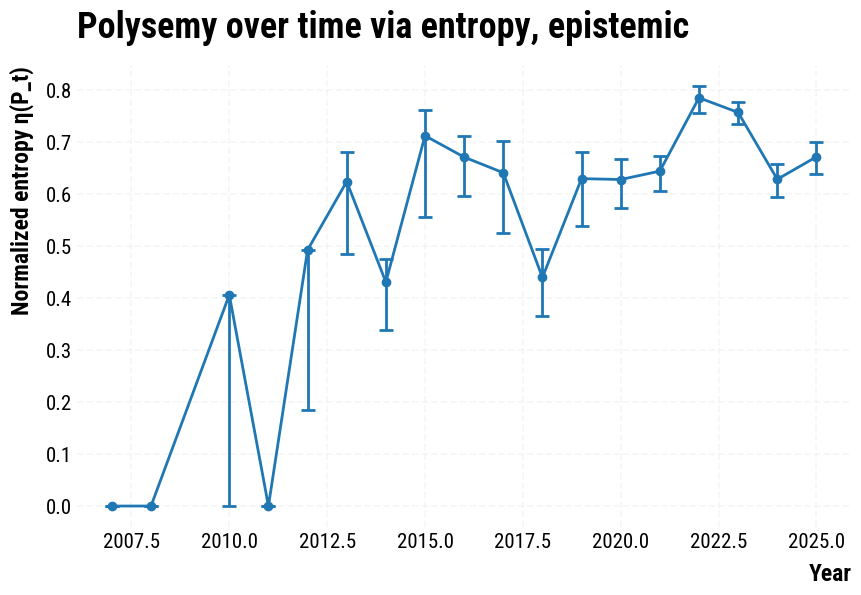

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs expected:
# - contexts: list of dicts with key 'year'
# - concept_cluster_labels: array-like of shape (N,) with cluster IDs for each context (aligned order)
# - key_phrase: only used for plotting titles

# ---------------- helpers ----------------
def relabel_to_compact(labels):
    """Map arbitrary labels to 0..K-1, return mapped array and K."""
    labels = np.asarray(labels)
    uniq, inv = np.unique(labels, return_inverse=True)
    K = uniq.size
    return inv.astype(int), K

def shannon_entropy(p):
    """Natural log. 0*log 0 is treated as 0 via clipping."""
    p = np.asarray(p, dtype=float)
    p = np.clip(p, 1e-12, 1.0)
    return float(-np.sum(p * np.log(p)))

def normalized_entropy_from_labels(labels_year, K):
    """Compute H(P_t)/log K for labels of one year."""
    n = labels_year.size
    if n == 0:
        return np.nan
    counts = np.bincount(labels_year, minlength=K).astype(float)
    
    p = counts / counts.sum() if counts.sum() > 0 else np.zeros(K)
    if K <= 1:
        return 0.0
    return shannon_entropy(p) / np.log(K), p

def bootstrap_eta(labels_year, K, n_boot=1000, seed=2025):
    """Percentile bootstrap CI for eta. Resample labels within the year."""
    n = labels_year.size
    if n < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    vals = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        vals[b] , _  = normalized_entropy_from_labels(labels_year[idx], K)
    return float(np.nanpercentile(vals, 2.5)), float(np.nanpercentile(vals, 97.5))

# ---------------- compute per year ----------------
# 1) Relabel clusters to 0..K-1 globally, and fix K for all years
labels_all, K = relabel_to_compact(concept_cluster_labels)

# 2) Collect per-year indices
unique_years = sorted(set(item['year'] for item in contexts))
year_to_indices = {y: [i for i, it in enumerate(contexts) if it['year'] == y] for y in unique_years}

# 3) Compute eta_t and bootstrap CIs
etas = []
ci_low = []
ci_high = []
p_all = []


N_BOOT = 1000  # bump if you want tighter CIs
for y in unique_years:
    idxs = year_to_indices[y]
    ly = labels_all[idxs]
    eta, p = normalized_entropy_from_labels(ly, K)
    p_all.append(p)
    lo, hi = bootstrap_eta(ly, K, n_boot=N_BOOT, seed=1234)
    etas.append(eta)
    ci_low.append(lo)
    ci_high.append(hi)

# ---------------- plot ----------------
etas = np.array(etas, float)
lo = np.array(ci_low, float)
hi = np.array(ci_high, float)

yerr_lower = np.where(np.isfinite(etas - lo), etas - lo, 0.0)
yerr_upper = np.where(np.isfinite(hi - etas), hi - etas, 0.0)
yerr = np.vstack([yerr_lower, yerr_upper])

plt.figure(figsize=(10, 6))
plt.errorbar(unique_years, etas, yerr=yerr, marker='o', linewidth=2, markersize=6, capsize=5, capthick=2)
plt.xlabel('Year')
plt.ylabel('Normalized entropy η(P_t)')
plt.title(f'Polysemy over time via entropy, {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

<Axes: >

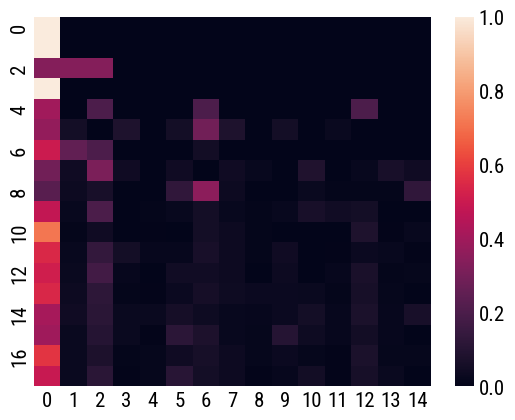

In [171]:
sns.heatmap(p_all)


Year 2007 - 5 most distant texts from centroid:
  1. Distance: 0.0412
     Text: He argues, for instance, that efforts to discover the molecular make-ups of entities identified at higher levels is often fruitful, even when identities between levels cannot be found. In addition, Wi...

  2. Distance: 0.0409
     Text: Instead, it is a functional concept that provides a uniform way to think about genes that can be applied to pick out different DNA segments in different investigative or explanatory contexts. The basi...


Year 2008 - 5 most distant texts from centroid:
  1. Distance: 0.0045
     Text: Tomasello, 1999 and Sterelny 2003 stress that niche construction, including downstream niche construction, is not limited to the physical world: animals make changes to their social and epistemic worl...

  2. Distance: 0.0038
     Text: However, the construction is not cumulative, since the nest is built anew each year. By contrast, a rabbit warren extended and elaborated over several gene

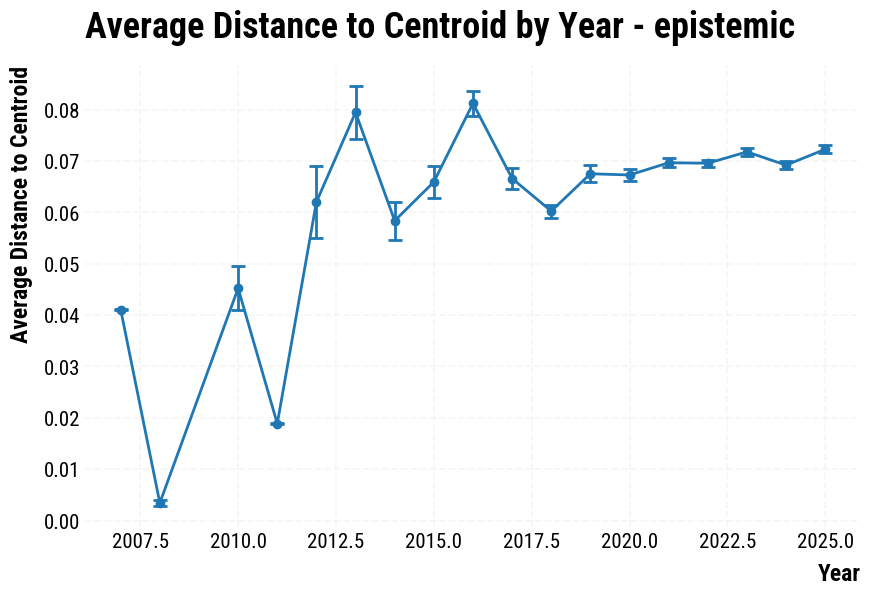

In [163]:
    # Get unique years and compute average distance to centroid for each year
    unique_years = sorted(set(item['year'] for item in contexts))
    year_distances = []
    year_std_errors = []

    for year in unique_years:
        # Get indices for this year
        year_indices = [i for i, item in enumerate(contexts) if item['year'] == year]
        
        if len(year_indices) > 1:  # Need at least 2 points to compute meaningful distances
            # Get embeddings for this year
            year_embeddings = key_phrase_embeddings[year_indices]
            
            # Compute centroid
            centroid = np.mean(year_embeddings, axis=0)
            
            # Compute distances from each point to centroid
            distances = [1 - np.dot(embedding, centroid) / (np.linalg.norm(embedding) * np.linalg.norm(centroid)) for embedding in year_embeddings]
            
            # Average distance and standard error
            avg_distance = np.mean(distances)
            std_error = np.std(distances) / np.sqrt(len(distances))  # Standard error of the mean
            year_distances.append(avg_distance)
            year_std_errors.append(std_error)
            
            # Find the 5 most distant points for this year
            distance_with_indices = [(dist, idx) for dist, idx in zip(distances, year_indices)]
            most_distant = sorted(distance_with_indices, key=lambda x: x[0], reverse=True)[:5]
            
            print(f"\nYear {year} - 5 most distant texts from centroid:")
            for i, (dist, original_idx) in enumerate(most_distant, 1):
                text_snippet = contexts[original_idx]['text'][:200] + "..." if len(contexts[original_idx]['text']) > 200 else contexts[original_idx]['text']
                print(f"  {i}. Distance: {dist:.4f}")
                print(f"     Text: {text_snippet}")
                print()
        else:
            year_distances.append(0)  # Single point has distance 0 to itself
            year_std_errors.append(0)  # No error for single point
            
            if len(year_indices) == 1:
                print(f"\nYear {year} - Only 1 text (distance to self = 0):")
                text_snippet = contexts[year_indices[0]]['text'][:200] + "..." if len(contexts[year_indices[0]]['text']) > 200 else contexts[year_indices[0]]['text']
                print(f"     Text: {text_snippet}")
                print()

    # Plot as line plot with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(unique_years, year_distances, yerr=year_std_errors, marker='o', linewidth=2, markersize=6, capsize=5, capthick=2)
    plt.xlabel('Year')
    plt.ylabel('Average Distance to Centroid')
    plt.title(f'Average Distance to Centroid by Year - {key_phrase}')
    plt.grid(True, alpha=0.3)
    plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


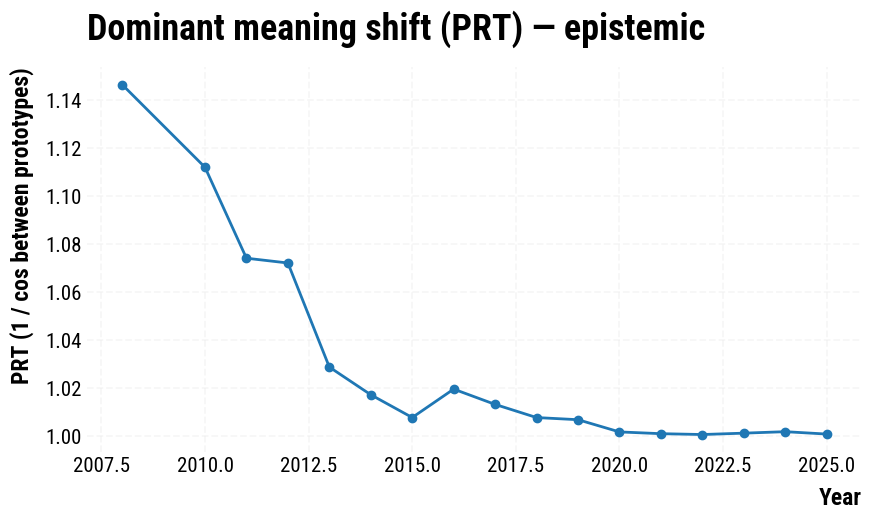

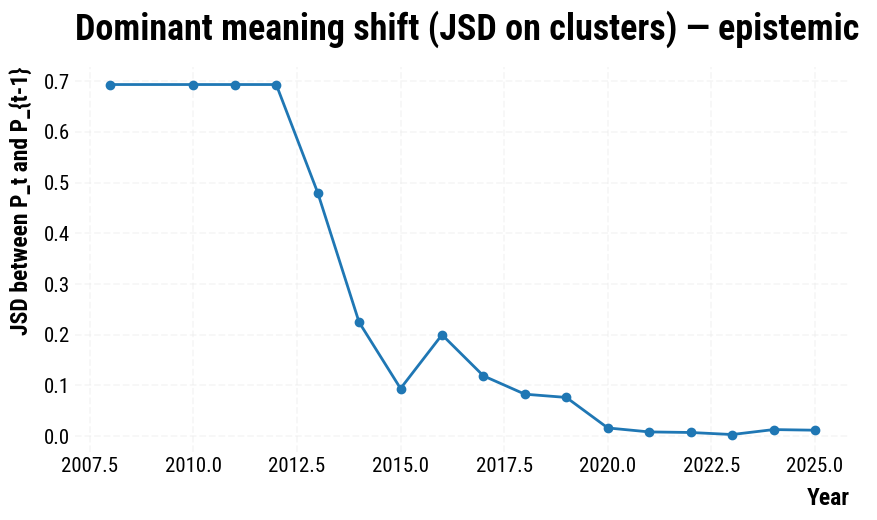

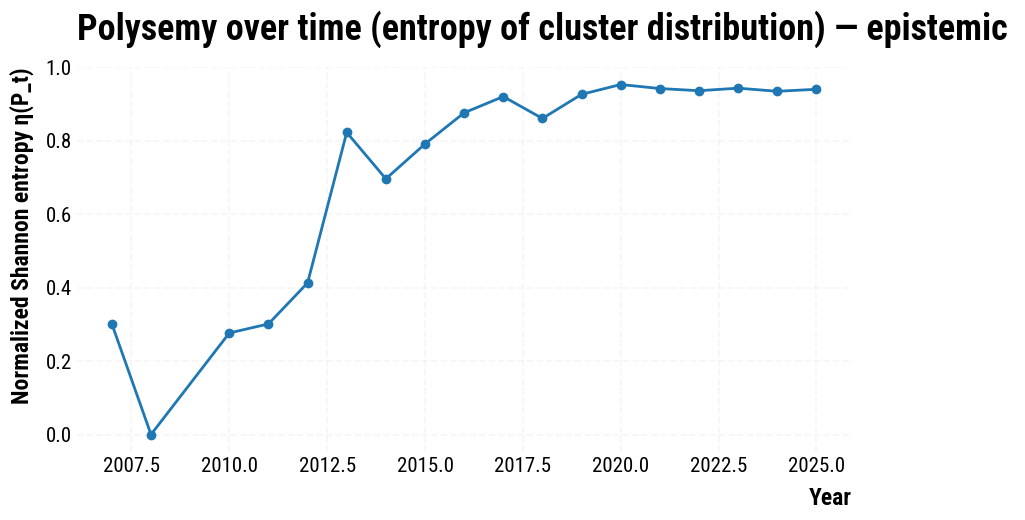

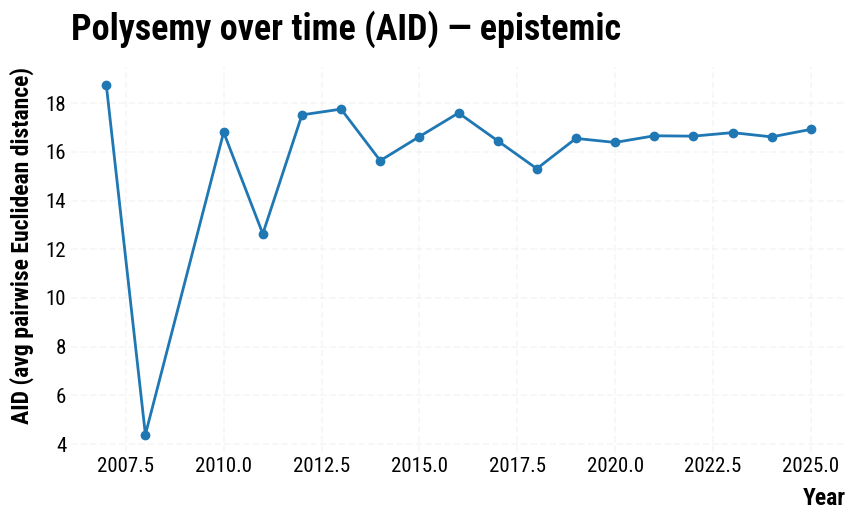

In [130]:
# ==== Zichert–Simons–Wüthrich SCD metrics, drop-in ====
# Inputs expected:
# - contexts: list of dicts with at least {'year': int, 'text': str}
# - key_phrase_embeddings: numpy array of shape (N, D) aligned with contexts
# - key_phrase: a string used only for plot titles

import numpy as np
import matplotlib.pyplot as plt

# ----------------- helpers from the paper -----------------
# Yearly prototype μ_t = mean of embeddings that year (dominant meaning rep)   [oai_citation:2‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_0000000059b061f4a47bc9631d9ccadf)
def cosine(u, v):
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu == 0 or nv == 0:
        return 0.0
    return float(np.dot(u, v) / (nu * nv))

# PRT = 1 / cosine(μ_t, μ_{t-1})  (higher means larger shift)   [oai_citation:3‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
def prt(mu_t, mu_prev):
    c = cosine(mu_t, mu_prev)
    return float(1.0 / max(c, 1e-12))

# JSD over yearly cluster distributions P_t  (dominant meaning, sense-based)   [oai_citation:4‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
def entropy(p):
    p = np.asarray(p, dtype=float)
    p = np.clip(p, 1e-12, 1.0)
    return float(-np.sum(p * np.log(p)))

def jsd(p, q):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    m = 0.5 * (p + q)
    return float(entropy(m) - 0.5 * (entropy(p) + entropy(q)))

# Normalized Shannon entropy η(P_t) = H(P_t) / log(N)  (polysemy)   [oai_citation:5‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
def normalized_entropy(p):
    p = np.asarray(p, dtype=float)
    N = p.size
    return float(entropy(p) / np.log(N))

# AID = average of all pairwise Euclidean distances within a year (polysemy)   [oai_citation:6‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
def average_inner_distance(X, max_pairs=500_000, rng=None):
    n = X.shape[0]
    if n < 2:
        return 0.0
    total_pairs = n * (n - 1) // 2
    if total_pairs <= max_pairs:
        # Compute all pairwise distances efficiently
        G = X @ X.T
        sq = np.sum(X * X, axis=1, keepdims=True)
        sq_d = sq + sq.T - 2.0 * G
        np.maximum(sq_d, 0.0, out=sq_d)
        d = np.sqrt(sq_d)
        iu = np.triu_indices(n, k=1)
        return float(d[iu].mean())
    else:
        if rng is None:
            rng = np.random.default_rng(0)
        i = rng.integers(0, n, size=max_pairs)
        j = rng.integers(0, n, size=max_pairs)
        mask = i != j
        i, j = i[mask], j[mask]
        diffs = X[i] - X[j]
        return float(np.mean(np.linalg.norm(diffs, axis=1)))

# Optional: PRT permutation test as in the paper’s robustness check   [oai_citation:7‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
def prt_permutation_pvalue(X_t, X_prev, n_perm=10000, rng=None):
    if rng is None:
        rng = np.random.default_rng(123)
    mu_t = X_t.mean(axis=0)
    mu_p = X_prev.mean(axis=0)
    obs = prt(mu_t, mu_p)
    pool = np.vstack([X_t, X_prev])
    n_t = X_t.shape[0]
    hits = 0
    for _ in range(n_perm):
        idx = rng.permutation(pool.shape[0])
        A = pool[idx[:n_t]]; B = pool[idx[n_t:]]
        muA = A.mean(axis=0); muB = B.mean(axis=0)
        val = prt(muA, muB)
        if val >= obs:
            hits += 1
    return (hits + 1) / (n_perm + 1)

def benjamini_hochberg(pvals):
    p = np.asarray(pvals, float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    adj = np.empty_like(ranked)
    cummin = 1.0
    for i in range(n - 1, -1, -1):
        rank = i + 1
        val = ranked[i] * n / rank
        cummin = min(cummin, val)
        adj[i] = cummin
    out = np.empty_like(adj)
    out[order] = adj
    return out

# ----------------- prepare year index -----------------
unique_years = sorted(set(item['year'] for item in contexts))
year_to_indices = {y: [i for i, it in enumerate(contexts) if it['year'] == y] for y in unique_years}

# ----------------- 1) Dominant meaning, form-based: PRT -----------------
year_prototypes = {}
for y, idxs in year_to_indices.items():
    Xy = key_phrase_embeddings[idxs]
    year_prototypes[y] = Xy.mean(axis=0) if Xy.size else np.zeros(key_phrase_embeddings.shape[1])

years_prt = []
prt_vals = []
for y_prev, y_curr in zip(unique_years[:-1], unique_years[1:]):
    val = prt(year_prototypes[y_curr], year_prototypes[y_prev])  # 1 / cosine(μ_t, μ_{t-1})   [oai_citation:8‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
    years_prt.append(y_curr); prt_vals.append(val)

# Optional: permutation tests for each adjacent pair (can be slow if many years)
# Set N_PERM small first, then increase if needed.
N_PERM = 0  # set to, e.g., 10000 to run tests as in the paper   [oai_citation:9‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
pvals = []
if N_PERM > 0:
    rng = np.random.default_rng(2024)
    for y_prev, y_curr in zip(unique_years[:-1], unique_years[1:]):
        Xc = key_phrase_embeddings[year_to_indices[y_curr]]
        Xp = key_phrase_embeddings[year_to_indices[y_prev]]
        pvals.append(prt_permutation_pvalue(Xc, Xp, n_perm=N_PERM, rng=rng))
    pvals_bh = benjamini_hochberg(pvals)

# ----------------- 2) Sense-based: global k-means on all embeddings, then yearly P_t -----------------
# As in the paper, fix N=10 clusters and cluster the full token set, then compute P_t per year.   [oai_citation:10‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_0000000059b061f4a47bc9631d9ccadf)
K = 10

def kmeans_fallback(X, k=K, seed=0, iters=100):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    # k-means++ init
    centers = [X[rng.integers(0, n)]]
    for _ in range(1, k):
        d2 = np.min([np.sum((X - c)**2, axis=1) for c in centers], axis=0)
        probs = d2 / (d2.sum() + 1e-12)
        centers.append(X[rng.choice(n, p=probs)])
    C = np.stack(centers, axis=0)

    for _ in range(iters):
        dists = np.sum((X[:, None, :] - C[None, :, :])**2, axis=2)
        lab = np.argmin(dists, axis=1)
        newC = np.zeros_like(C)
        for j in range(k):
            mask = lab == j
            newC[j] = X[mask].mean(axis=0) if np.any(mask) else C[j]
        if np.allclose(newC, C):
            break
        C = newC
    return lab, C

X_all = key_phrase_embeddings
try:
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=K, n_init=10, random_state=0)
    labels = km.fit_predict(X_all)
    centers = km.cluster_centers_
except Exception:
    labels, centers = kmeans_fallback(X_all, k=K, seed=0)

# Yearly cluster distributions P_t and entropy η(P_t)   [oai_citation:11‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_0000000059b061f4a47bc9631d9ccadf)
year_P = {}
year_entropy = {}
for y, idxs in year_to_indices.items():
    if len(idxs) == 0:
        P = np.zeros(K)
    else:
        counts = np.bincount(labels[idxs], minlength=K).astype(float)
        P = counts / max(1, counts.sum())
    year_P[y] = P
    year_entropy[y] = normalized_entropy(P)  # H(P_t)/log(K)   [oai_citation:12‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)

# JSD between consecutive years’ distributions   [oai_citation:13‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
years_jsd = []
jsd_vals = []
for y_prev, y_curr in zip(unique_years[:-1], unique_years[1:]):
    years_jsd.append(y_curr)
    jsd_vals.append(jsd(year_P[y_prev], year_P[y_curr]))

# ----------------- 3) Polysemy: AID per year   [oai_citation:14‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
years_aid = []
aid_vals = []
for y in unique_years:
    Xy = key_phrase_embeddings[year_to_indices[y]]
    years_aid.append(y)
    aid_vals.append(average_inner_distance(Xy, max_pairs=500_000))

# ----------------- Plots to match the paper’s panels -----------------
plt.figure(figsize=(10, 5))
plt.plot(years_prt, prt_vals, marker='o', linewidth=2)
plt.xlabel('Year'); plt.ylabel('PRT (1 / cos between prototypes)')
plt.title(f'Dominant meaning shift (PRT) — {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(years_jsd, jsd_vals, marker='o', linewidth=2)
plt.xlabel('Year'); plt.ylabel('JSD between P_t and P_{t-1}')
plt.title(f'Dominant meaning shift (JSD on clusters) — {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(unique_years, [year_entropy[y] for y in unique_years], marker='o', linewidth=2)
plt.xlabel('Year'); plt.ylabel('Normalized Shannon entropy η(P_t)')
plt.title(f'Polysemy over time (entropy of cluster distribution) — {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(years_aid, aid_vals, marker='o', linewidth=2)
plt.xlabel('Year'); plt.ylabel('AID (avg pairwise Euclidean distance)')
plt.title(f'Polysemy over time (AID) — {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

# Optional: show permutation-test p-values for PRT, with BH correction   [oai_citation:15‡Zichert-Simons-Wuethrich-Virtual-Particle.pdf](sediment://file_00000000a1386243bb656f4c2d820235)
if N_PERM > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(years_prt, pvals, marker='o', linewidth=1, label='p-values (unadjusted)')
    plt.plot(years_prt, pvals_bh, marker='o', linewidth=1, label='p-values (BH)')
    plt.axhline(0.05, linestyle='--', label='0.05')
    plt.xlabel('Year'); plt.ylabel('p-value')
    plt.title(f'Permutation testing for PRT — {key_phrase}')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

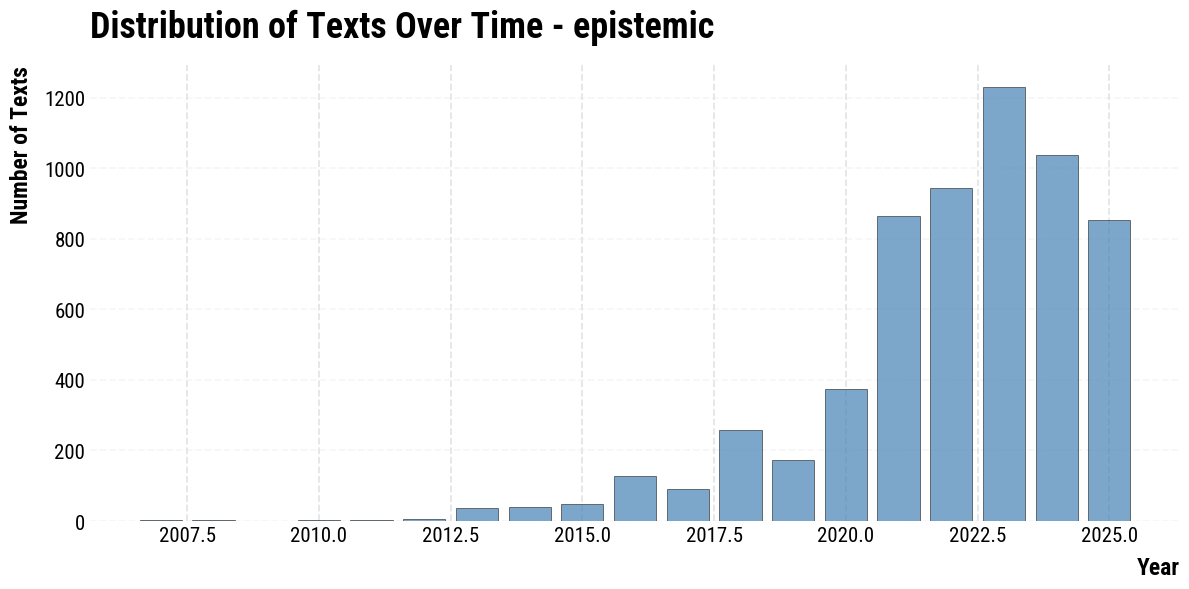

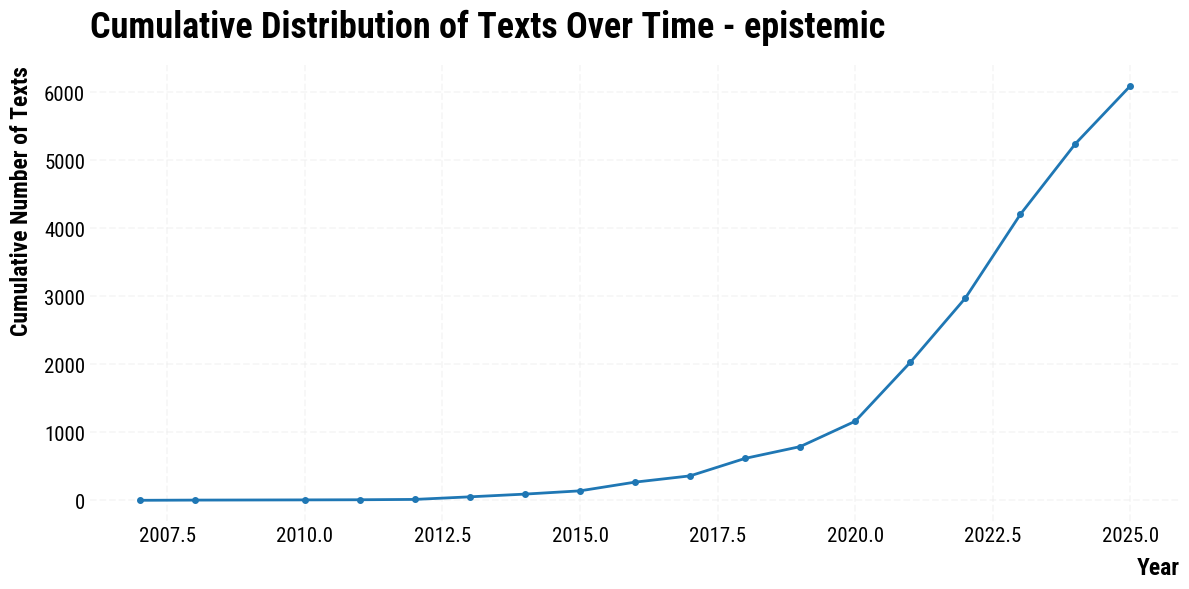

In [128]:
# Plot years over time - simple timeline visualization
plt.figure(figsize=(12, 6))

# Count occurrences per year
year_counts = {}
for item in contexts:
    year = item['year']
    year_counts[year] = year_counts.get(year, 0) + 1

# Sort years and get counts
sorted_years = sorted(year_counts.keys())
counts = [year_counts[year] for year in sorted_years]

# Create bar plot
plt.bar(sorted_years, counts, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Number of Texts')
plt.title(f'Distribution of Texts Over Time - {key_phrase}')
plt.grid(True, alpha=0.3, axis='y')

# Rotate x-axis labels if there are many years
if len(sorted_years) > 20:
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also create a cumulative plot
plt.figure(figsize=(12, 6))
cumulative_counts = np.cumsum(counts)
plt.plot(sorted_years, cumulative_counts, marker='o', linewidth=2, markersize=4)
plt.xlabel('Year')
plt.ylabel('Cumulative Number of Texts')
plt.title(f'Cumulative Distribution of Texts Over Time - {key_phrase}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


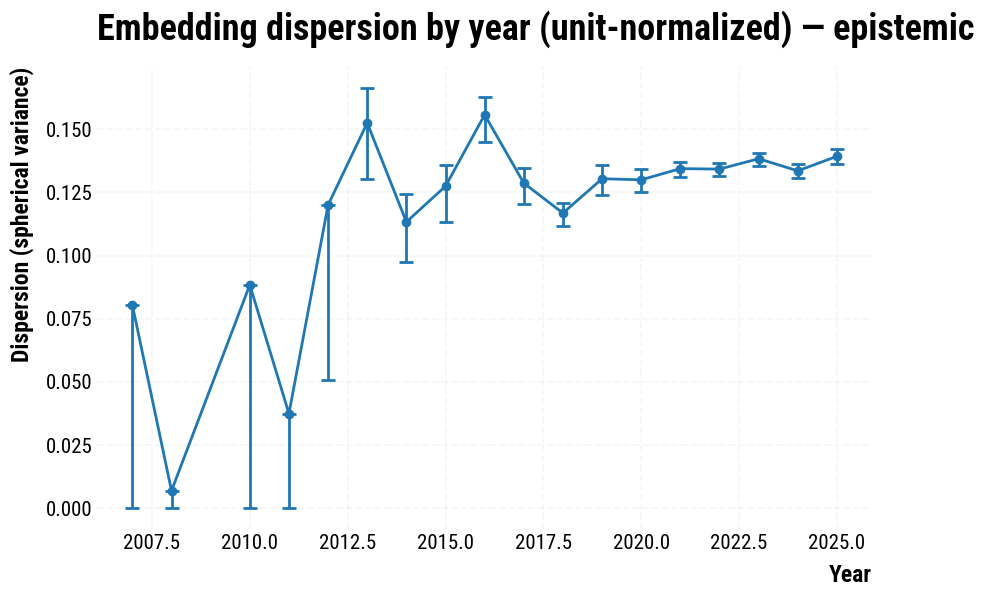

ValueError: 'yerr' must not contain negative values

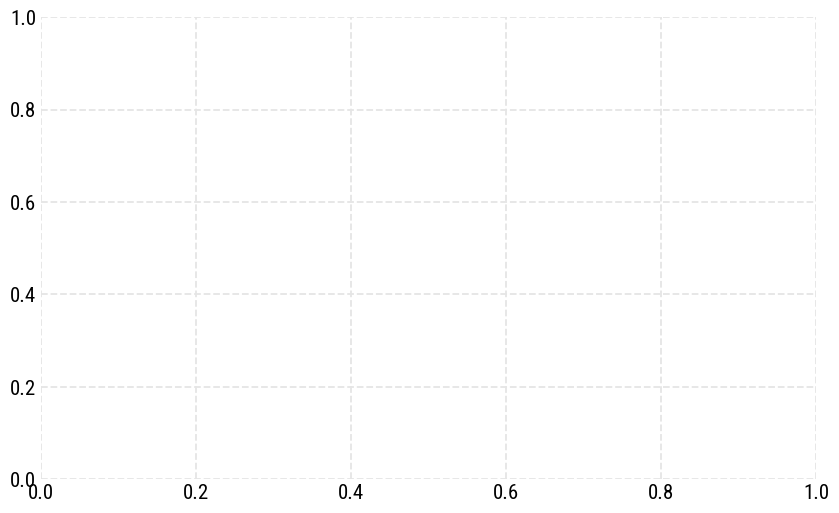

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- helpers -----------------
def unit_normalize(X):
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    nrm = np.where(nrm == 0.0, 1.0, nrm)
    return X / nrm

def variance_yamagiwa(X):
    """
    Var(X) = E||X||^2 - ||E[X]||^2  (Yamagiwa & Shimodaira)
    Works for any vectors. If X rows are unit-normalized, this reduces to 1 - ||mean||^2.
    """
    if X.size == 0:
        return np.nan
    mean_vec = X.mean(axis=0)
    ex2 = np.mean(np.sum(X * X, axis=1))
    return float(ex2 - np.dot(mean_vec, mean_vec))

def bootstrap_var(X, n_boot=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng(2024)
    n = X.shape[0]
    if n < 2:
        return (np.nan, np.nan)
    vals = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        vals[b] = variance_yamagiwa(X[idx])
    return np.nanpercentile(vals, 2.5), np.nanpercentile(vals, 97.5)

# ----------------- per-year computation -----------------
unique_years = sorted(set(item['year'] for item in contexts))

raw_var, raw_low, raw_high = [], [], []
sph_var, sph_low, sph_high = [], [], []

N_BOOT = 1000
rng = np.random.default_rng(42)

for year in unique_years:
    idxs = [i for i, item in enumerate(contexts) if item['year'] == year]
    X_year = key_phrase_embeddings[idxs]

    # Raw variance (no normalization)
    v_raw = variance_yamagiwa(X_year)
    l_raw, h_raw = bootstrap_var(X_year, n_boot=N_BOOT, rng=rng)

    # Spherical variance on L2-normalized embeddings: Var = 1 - ||mean||^2
    X_unit = unit_normalize(X_year)
    v_sph = variance_yamagiwa(X_unit)        # equals 1 - ||mean_unit||^2
    l_sph, h_sph = bootstrap_var(X_unit, n_boot=N_BOOT, rng=rng)

    raw_var.append(v_raw);   raw_low.append(l_raw);   raw_high.append(h_raw)
    sph_var.append(v_sph);   sph_low.append(l_sph);   sph_high.append(h_sph)

# ----------------- plots -----------------
def _err(y, lo, hi):
    y = np.array(y, float); lo = np.array(lo, float); hi = np.array(hi, float)
    lower = np.where(np.isfinite(y - lo), y - lo, 0.0)
    upper = np.where(np.isfinite(hi - y), hi - y, 0.0)
    return np.vstack([lower, upper])

plt.figure(figsize=(10, 6))
plt.errorbar(unique_years, sph_var, yerr=_err(sph_var, sph_low, sph_high),
             marker='o', linewidth=2, markersize=6, capsize=5, capthick=2)
plt.xlabel('Year')
plt.ylabel('Dispersion (spherical variance)')
plt.title(f'Embedding dispersion by year (unit-normalized) — {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(unique_years, raw_var, yerr=_err(raw_var, raw_low, raw_high),
             marker='o', linewidth=2, markersize=6, capsize=5, capthick=2)
plt.xlabel('Year')
plt.ylabel('Dispersion (raw variance)')
plt.title(f'Embedding dispersion by year (raw) — {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

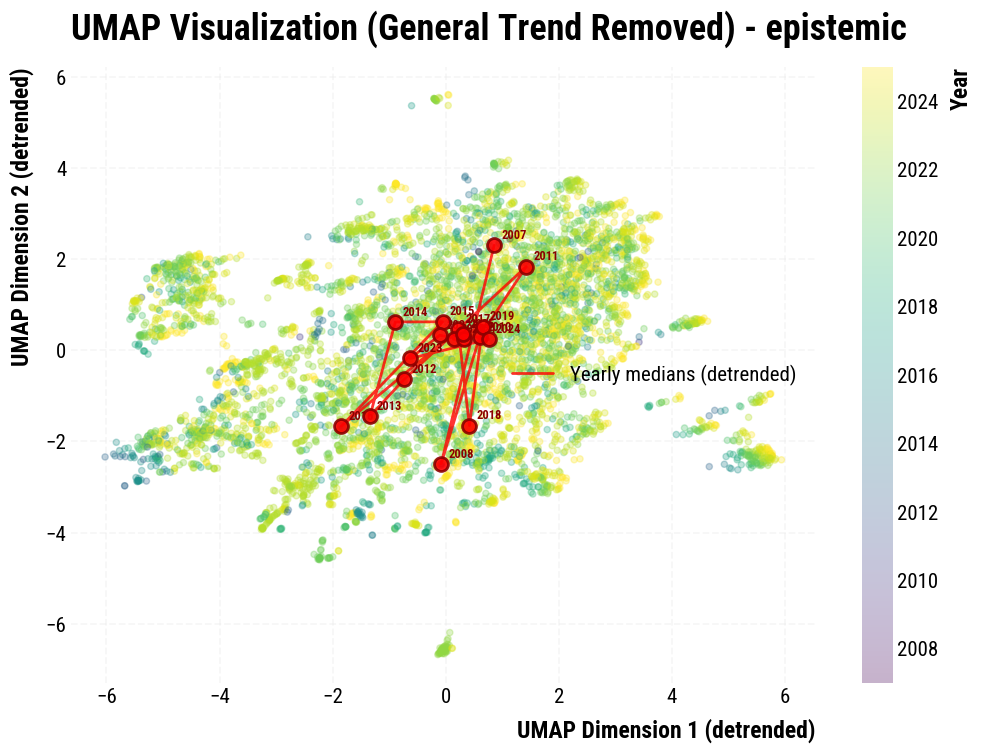

In [132]:
# Plot yearwise medians in the 2D UMAP data, linked by line
plt.figure(figsize=(12, 8))

# Calculate yearly medians in UMAP space first
yearly_medians = {}
for year in unique_years:
    year_indices = [i for i, item in enumerate(contexts) if item['year'] == year]
    if year_indices:
        year_umap_points = key_phrase_umap_embeddings[year_indices]
        median_x = np.median(year_umap_points[:, 0])
        median_y = np.median(year_umap_points[:, 1])
        yearly_medians[year] = (median_x, median_y)

# Calculate the overall trajectory (general component)
years_sorted = sorted(yearly_medians.keys())
median_coords = np.array([yearly_medians[year] for year in years_sorted])

# Fit a linear trend to the yearly medians to capture general drift
from sklearn.linear_model import LinearRegression
if len(median_coords) > 1:
    reg = LinearRegression()
    years_reshaped = np.array(years_sorted).reshape(-1, 1)
    reg.fit(years_reshaped, median_coords)
    
    # Predict the general trend for each year
    general_trend = reg.predict(years_reshaped)
    
    # Remove general trend from yearly medians
    detrended_medians = median_coords - general_trend
    
    # Apply the same detrending to individual points
    detrended_points = []
    detrended_years = []
    
    for i, item in enumerate(contexts):
        year = item['year']
        year_idx = years_sorted.index(year) if year in years_sorted else None
        if year_idx is not None:
            # Remove the general trend component for this year
            trend_offset = general_trend[year_idx]
            detrended_point = key_phrase_umap_embeddings[i] - trend_offset
            detrended_points.append(detrended_point)
            detrended_years.append(year)
    
    detrended_points = np.array(detrended_points)
    
    # Plot detrended points
    scatter = plt.scatter(detrended_points[:, 0], detrended_points[:, 1], 
                         c=detrended_years, 
                         cmap='viridis', alpha=0.3, s=20)
    
    # Plot detrended yearly medians
    plt.plot(detrended_medians[:, 0], detrended_medians[:, 1], 'r-', linewidth=2, alpha=0.8, label='Yearly medians (detrended)')
    plt.scatter(detrended_medians[:, 0], detrended_medians[:, 1], c='red', s=100, alpha=0.9, 
               edgecolors='darkred', linewidth=2, zorder=5)
    
    # Add year labels to the detrended median points
    for i, year in enumerate(years_sorted):
        x, y = detrended_medians[i]
        plt.annotate(str(year), (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', color='darkred')
    
    plt.title(f'UMAP Visualization (General Trend Removed) - {key_phrase}')
    
else:
    # Fallback if not enough points for trend fitting
    scatter = plt.scatter(key_phrase_umap_embeddings[:, 0], key_phrase_umap_embeddings[:, 1], 
                         c=[item['year'] for item in contexts], 
                         cmap='viridis', alpha=0.3, s=20)
    plt.title(f'UMAP Visualization - {key_phrase}')

plt.colorbar(scatter, label='Year')
plt.xlabel('UMAP Dimension 1 (detrended)')
plt.ylabel('UMAP Dimension 2 (detrended)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


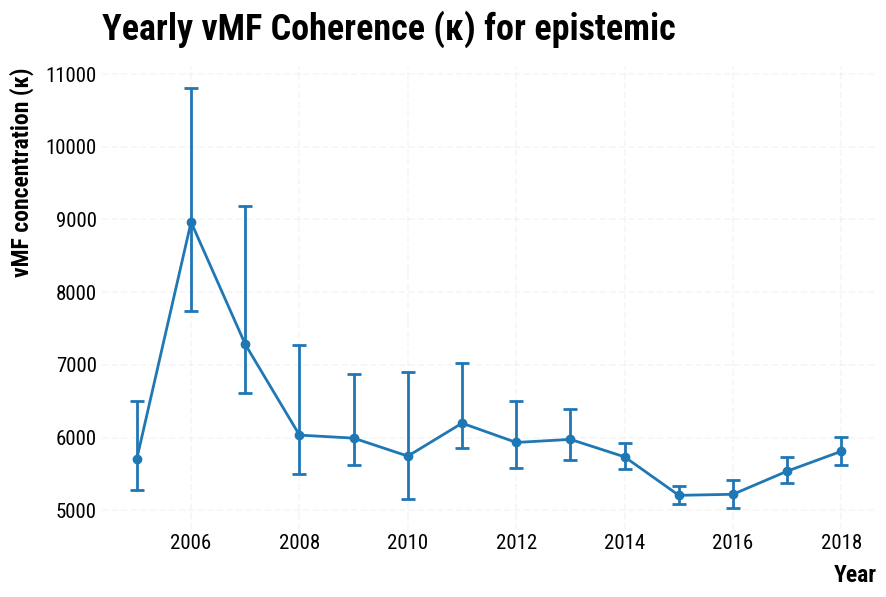

/Users/Noich001/Desktop/OZSW2025-data-driven-philosophy/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 772 (\N{COMBINING MACRON}) missing from font(s) Roboto Condensed.
  fig.canvas.print_figure(bytes_io, **kw)


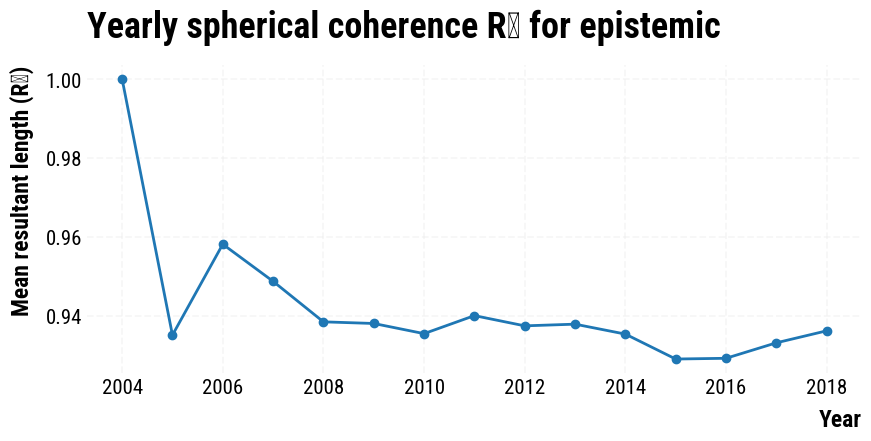

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- vMF helpers ----------
def unit_normalize(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.where(norms == 0.0, 1.0, norms)
    return X / norms

def rbar_and_kappa(X):
    """
    X: (n, d) embeddings for one year (not necessarily unit length).
    Returns:
      rbar in [0, 1]
      kappa >= 0 (np.inf if perfectly concentrated, np.nan if undefined)
    """
    if X.ndim != 2 or X.shape[0] == 0:
        return np.nan, np.nan

    Xn = unit_normalize(X)
    m = Xn.mean(axis=0)
    rbar = float(np.linalg.norm(m))
    p = Xn.shape[1]

    if np.isclose(rbar, 1.0):
        kappa = np.inf   # single point or identical directions
    elif rbar <= 0.0 or not np.isfinite(rbar):
        kappa = np.nan
    else:
        # High-dim approximation used in movMF/Banerjee-Sra literature
        kappa = rbar * (p - rbar**2) / max(1e-12, (1.0 - rbar**2))
        kappa = max(0.0, float(kappa))
    return rbar, kappa

def bootstrap_kappa(X, n_boot=1000, rng=None):
    """
    Nonparametric bootstrap for kappa with percentile CI.
    Returns (low, high). If not enough samples, returns (np.nan, np.nan).
    """
    n = X.shape[0]
    if n < 2:
        return (np.nan, np.nan)
    if rng is None:
        rng = np.random.default_rng(123)

    ks = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        _, kb = rbar_and_kappa(X[idx])
        ks[b] = kb
    return (np.nanpercentile(ks, 2.5), np.nanpercentile(ks, 97.5))

# ---------- Per-year computation ----------
unique_years = sorted(set(item['year'] for item in contexts))

year_rbars = []
year_kappas = []
ci_low = []
ci_high = []

# Optional: how many bootstrap resamples
N_BOOT = 1000
rng = np.random.default_rng(2024)

for year in unique_years:
    year_indices = [i for i, item in enumerate(contexts) if item['year'] == year]
    X_year = key_phrase_embeddings[year_indices]

    rbar, kappa = rbar_and_kappa(X_year)

    # Bootstrap CI only when there is more than one item and kappa is finite
    if len(year_indices) > 1 and np.isfinite(kappa):
        low, high = bootstrap_kappa(X_year, n_boot=N_BOOT, rng=rng)
    else:
        low, high = (np.nan, np.nan)

    year_rbars.append(rbar)
    year_kappas.append(kappa)
    ci_low.append(low)
    ci_high.append(high)

    # Optional: print a quick summary per year
    # print(f"Year {year}: Rbar={rbar:.4f}, kappa={kappa:.3f}, CI=({low:.3f}, {high:.3f})")

# ---------- Plot κ with 95% bootstrap CIs ----------
# Build asymmetric error bars from the percentile CIs
kappas = np.array(year_kappas, dtype=float)
low = np.array(ci_low, dtype=float)
high = np.array(ci_high, dtype=float)

yerr_lower = kappas - low
yerr_upper = high - kappas

# If any entries are nan or inf, replace yerr parts with zeros to avoid plotting issues
yerr_lower = np.where(np.isfinite(yerr_lower), yerr_lower, 0.0)
yerr_upper = np.where(np.isfinite(yerr_upper), yerr_upper, 0.0)
yerr = np.vstack([yerr_lower, yerr_upper])

plt.figure(figsize=(10, 6))
plt.errorbar(unique_years, kappas, yerr=yerr, marker='o', linewidth=2, markersize=6, capsize=5, capthick=2)
plt.xlabel('Year')
plt.ylabel('vMF concentration (κ)')
plt.title(f'Yearly vMF Coherence (κ) for {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

# ---------- (Optional) also plot R̄ ----------
plt.figure(figsize=(10, 4))
plt.plot(unique_years, year_rbars, marker='o', linewidth=2, markersize=6)
plt.xlabel('Year')
plt.ylabel('Mean resultant length (R̄)')
plt.title(f'Yearly spherical coherence R̄ for {key_phrase}')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
years_arr = np.array([it['year'] for it in contexts])
unique_years = np.unique(years_arr)

# Option A: center all points by global mean
global_mean = key_phrase_umap_embeddings.mean(axis=0)
emb_centered = key_phrase_umap_embeddings - global_mean

# Option B: center by a baseline year median
baseline_year = int(np.min(unique_years))  # or pick one explicitly
b_idx = np.where(years_arr == baseline_year)[0]
baseline_median = np.median(key_phrase_umap_embeddings[b_idx], axis=0)
emb_centered = key_phrase_umap_embeddings - baseline_median  # use this for plotting below

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

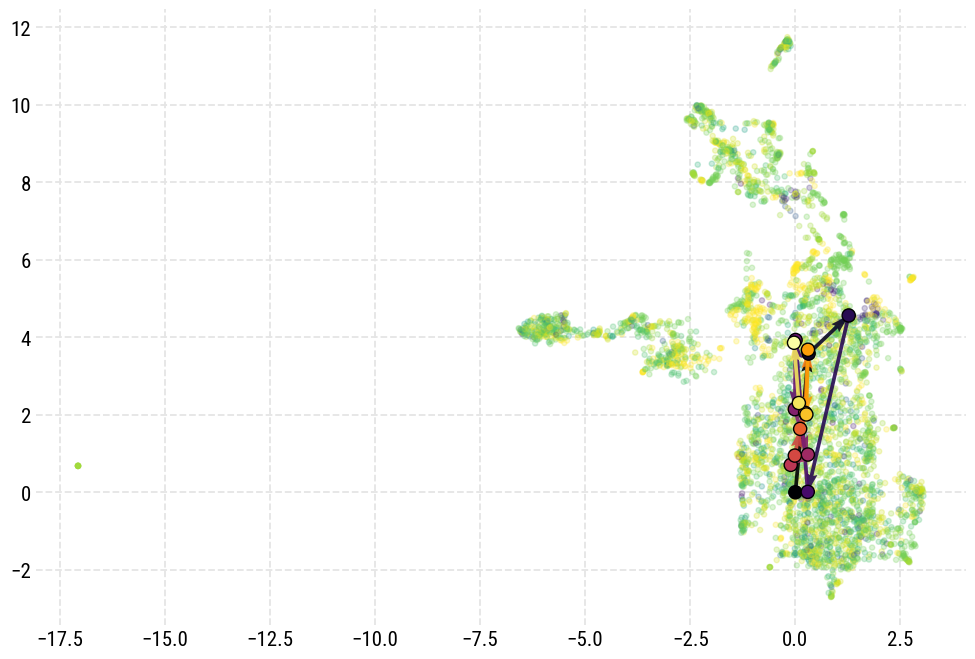

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

plt.figure(figsize=(12, 8))

# Lighter background scatter
scatter = plt.scatter(
    emb_centered[:,0], emb_centered[:,1],
    c=years_arr, cmap='viridis', alpha=0.25, s=14
)

# Yearly medians in the centered space
yearly_medians = {}
for y in unique_years:
    idx = np.where(years_arr == y)[0]
    pts = emb_centered[idx]
    if len(pts):
        yearly_medians[y] = np.median(pts, axis=0)

years_sorted = sorted(yearly_medians)
med = np.array([yearly_medians[y] for y in years_sorted])

# Color by time
norm = Normalize(vmin=min(years_sorted), vmax=max(years_sorted))
cmap = plt.get_cmap('inferno')
colors = [cmap(norm(y)) for y in years_sorted]

# Median points
plt.scatter(med[:,0], med[:,1], c=years_sorted, cmap='inferno',
            s=90, edgecolors='k', linewidth=1.0, zorder=5)

# Arrows between consecutive years
dx = np.diff(med[:,0])
dy = np.diff(med[:,1])
plt.quiver(
    med[:-1,0], med[:-1,1], dx, dy,
    angles='xy', scale_units='xy', scale=1,
    color=[cmap(norm(y)) for y in years_sorted[:-1]],
    width=0.004, alpha=0.9, zorder=4
)

plt.colorbar(ScalarMappable(norm=norm, cmap='inferno'), label='Year')
plt.xlabel('UMAP 1 (centered)')
plt.ylabel('UMAP 2 (centered)')
plt.title(f'{key_phrase} | yearly shift of median in UMAP space')
plt.grid(True, alpha=0.25)
plt.show()

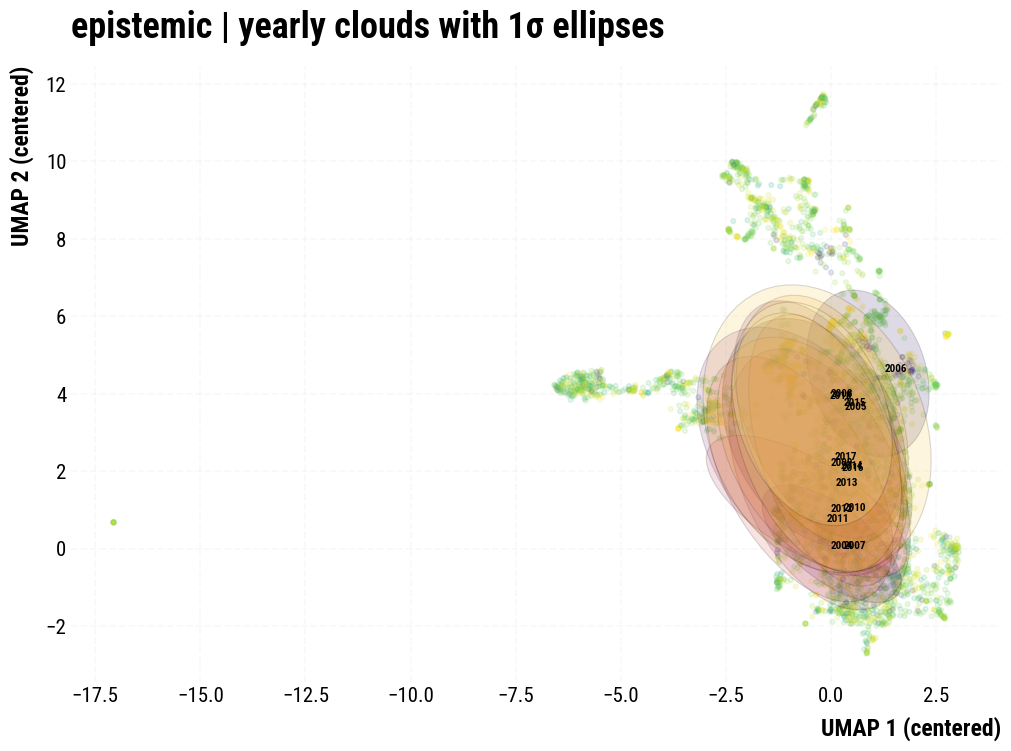

In [ ]:
from matplotlib.patches import Ellipse

def draw_cov_ellipse(points, ax, n_std=1.0, **kwargs):
    if len(points) < 3:
        return
    cov = np.cov(points, rowvar=False)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    w, h = 2 * n_std * np.sqrt(vals)
    mean = points.mean(axis=0)
    e = Ellipse(xy=mean, width=w, height=h, angle=theta, **kwargs)
    ax.add_patch(e)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(emb_centered[:,0], emb_centered[:,1], c=years_arr, cmap='viridis', alpha=0.15, s=12)

for y in years_sorted:
    idx = np.where(years_arr == y)[0]
    pts = emb_centered[idx]
    col = cmap(norm(y))
    draw_cov_ellipse(
        pts, ax, n_std=1.0,
        facecolor=col, edgecolor='k', linewidth=0.8, alpha=0.15
    )
    ax.text(*yearly_medians[y], str(y), fontsize=8, weight='bold', color='black')

ax.set_xlabel('UMAP 1 (centered)')
ax.set_ylabel('UMAP 2 (centered)')
ax.set_title(f'{key_phrase} | yearly clouds with 1σ ellipses')
ax.grid(True, alpha=0.25)
plt.show()

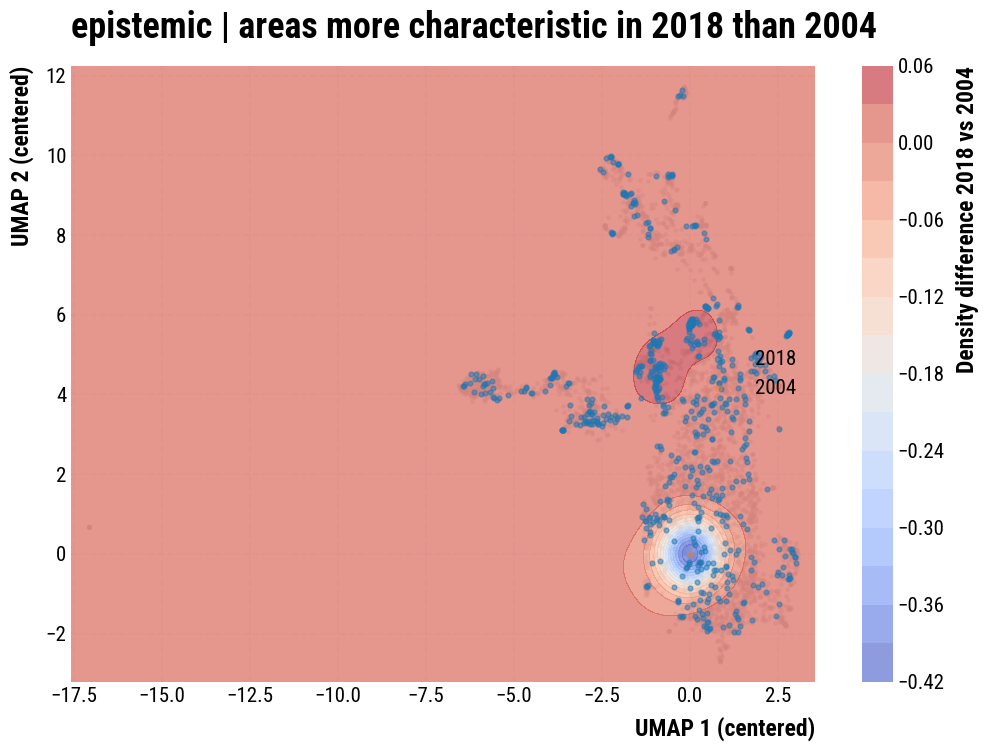

In [ ]:
from sklearn.neighbors import KernelDensity

def kde_grid(points, xg, yg, bw=0.5):
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(points)
    XY = np.vstack([xg.ravel(), yg.ravel()]).T
    z = np.exp(kde.score_samples(XY)).reshape(xg.shape)
    return z

# pick target year to compare against baseline_year
target_year = int(max(years_sorted))  # or loop over years

# grid over the centered space
x_min, y_min = emb_centered.min(axis=0) - 0.5
x_max, y_max = emb_centered.max(axis=0) + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

B = emb_centered[years_arr == baseline_year]
T = emb_centered[years_arr == target_year]

Zb = kde_grid(B, xx, yy, bw=0.6)
Zt = kde_grid(T, xx, yy, bw=0.6)
Zdiff = Zt - Zb  # positive means "more characteristic in target year"

plt.figure(figsize=(12,8))
plt.scatter(emb_centered[:,0], emb_centered[:,1], c='lightgray', s=6, alpha=0.3)
plt.contourf(xx, yy, Zdiff, levels=15, cmap='coolwarm', alpha=0.6)
plt.colorbar(label=f'Density difference {target_year} vs {baseline_year}')
plt.scatter(T[:,0], T[:,1], s=12, alpha=0.5, label=str(target_year))
plt.scatter(B[:,0], B[:,1], s=12, alpha=0.3, label=str(baseline_year))
plt.legend()
plt.title(f'{key_phrase} | areas more characteristic in {target_year} than {baseline_year}')
plt.xlabel('UMAP 1 (centered)')
plt.ylabel('UMAP 2 (centered)')
plt.grid(True, alpha=0.25)
plt.show()